# Evaluation of the fixed dropout version

* [Attention visualisation](#Attention-visualisation)
  * [Code to create the visualisation](#Code-to-create-the-visualisation)
  * [Visualisation of differently trained models](#Visualisation-of-differently-trained-models)
    * [Attention on training set](#Attention-on-training-set)
    * [Attention on test set 2013](#Attention-on-test-set-2013)
    * [Attention on test set 2016](#Attention-on-test-set-2016)
* [Beam search](#Beam-search)
  * [Sequence comparison](#Sequence-comparison)
    * [Beam of training set](#Beam-of-training-set)
    * [Beam of test set 2013](#Beam-of-test-set-2013)
    * [Beam of test set 2014](#Beam-of-test-set-2014)
    * [Beam of test set 2016](#Beam-of-test-set-2016)
  * [Observations](#Observations)
* [Evaluation of the model](#Evaluation-of-the-model)
  * [Summary](#Summary)
  * [Dataset Train](#Dataset-Train)
    * [Highest Probability - Train](#Highest-Probability---Train)
    * [Best - Train](#Best---Train)
    * [Mean - Train](#Mean---Train)
  * [Dataset 2013](#Dataset-2013)
    * [Highest Probability - 2013](#Highest-Probability---2013)
    * [Best - 2013](#Best---2013)
    * [Mean - 2013](#Mean---2013)
  * [Dataset 2014](#Dataset-2014)
    * [Highest Probability - 2014](#Highest-Probability---2014)
    * [Best - 2014](#Best---2014)
    * [Mean - 2014](#Mean---2014)
  * [Dataset 2016](#Dataset-2016)
    * [Highest Probability - 2016](#Highest-Probability---2016)
    * [Best - 2016](#Best---2016)
    * [Mean - 2016](#Mean---2016)


In [1]:
%%html
<!-- Left aligns the markdown tables -->
<style>
  table {margin-left: 0 !important;}
</style>

This evaluation focuses on the fixed dropout version, which uses dropout only after each dense layer, which corresponds to one layer within a dense block, as in the standard DenseNet architecture. In our case this is a bottleneck layer.

## Attention visualisation

> This is the same as in the previous evaluation, just with different checkpoints.

There are two attention vectors, a low resolution and a high resolution one. Since they are vectors, it wouldn't directly translate to an image, but they are multiplied elemntwise with the low and high resolution annotation sequences respectively, which are in the form of A = { a1, ..., aL } and B = { b1, ..., b4L }, where A is the low resolution and B the high resolution annotation sequence. The annotation sequences are essentially a flattened version of the features, where `L = H x W` and `4L = 2H x 2W`. From this we can assume that the attention translates in the same regard to the image. Hence the attention is then upscaled to match the image size.

### Code to create the visualisation

In [2]:
# To make it possible to import the code
import sys
sys.path.append("..")

In [3]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import skimage.transform
import torch
import torchvision.transforms as transforms
import evaluate
import train
from IPython.display import display, Markdown
from torch.utils.data import DataLoader
from checkpoint import default_checkpoint, load_checkpoint
from model import Encoder, Decoder
from dataset import CrohmeDataset, START, PAD, collate_batch
%matplotlib inline

In [4]:
batch_size = 4
use_cuda = False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
def print_predictions(preds, expected):
    header = "|  Time step  |  Expected  |"
    lines = []
    for i in range(len(expected)):
        line = "|  {t:>{pad_time}}  |  `{exp:>{pad_exp}}`  |".format(
                  t=i,
                  exp=expected[i],
                  pad_time=len("Time step"),
                  pad_exp=len("Expected")
              )
        for name, pred in preds.items():
            if i == 0:
                header += "  {}  |".format(name)
            # Tokens are put in a code block, because the special tokens are within
            # angle brackets and they would be treated as HTML tags in the markdown.
            line += "  `{pred:>{pad_pred}}`  |".format(pred=pred[i], pad_pred=len(name))
        lines.append(line)
        
    table = "{header}\n{delimiter}\n{lines}".format(header=header, delimiter=re.sub("[^|]", "-", header), lines="\n".join(lines))
    display(Markdown(table))

In [6]:
to_pil_image = transforms.ToPILImage()

def show_attention_images(img, results, batch_num, smooth=False):
    pil_img = to_pil_image(img)
    _, h, w = img.size()
    timesteps = max(res["attn_low"][batch_num].size(0) for res in results)
    num_axes = 2*len(results)
    fig, axes = plt.subplots(timesteps, num_axes, figsize=(3.5*num_axes, 3*timesteps))
    for i in range(num_axes):
        # Each result is used in two axes
        curr_res = results[i // 2]
        # The first axis is for the low resolution and the second axis for the high resolution
        attn = curr_res["attn_low"] if i % 2 == 0 else curr_res["attn_high"]
        # Resize attentions from flat to 2D (L = H x W)
        res_size = curr_res["low_res_size"] if i % 2 == 0 else curr_res["high_res_size"]
        attn = attn[batch_num].view(-1, res_size[2], res_size[3])
        _, attn_h, attn_w = attn.size()
        attn = attn.detach().cpu().numpy()
        upscale_factor = max(h // attn_h, w // attn_w)
        if i % 2 == 0:
            axes[0][i].set_title("Low resolution")
            axes[0][i].text(0.7, 1.2, curr_res["name"], transform=axes[0][i].transAxes, fontsize=15)
        else:
            axes[0][i].set_title("High resolution")
        for t in range(timesteps):
            ax = axes[t][i]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(pil_img)
            attn_mask = (
                skimage.transform.pyramid_expand(
                    attn[t], upscale=upscale_factor, multichannel=False)
                if smooth
                else skimage.transform.resize(attn[t], (h, w), mode="reflect", anti_aliasing=True)
            )
            attn_img = ax.imshow(attn_mask, alpha=0.7)
            attn_img.set_cmap(cm.Greys_r)
            if i % 2 == 0:
                ax.text(1.03, 0.5, "{:>5}".format(curr_res["preds"][batch_num][t]), transform=ax.transAxes, fontsize=15)

    plt.show()

In [7]:
def create_batch(truth, tokens, root=".", batch_size=batch_size):
    dataset = CrohmeDataset(truth, tokens, root=root, transform=evaluate.transformers)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_batch,
    )
    
    data_iter = iter(data_loader)
    batch = next(data_iter)
    return batch, dataset.id_to_token, dataset.token_to_id

In [8]:
def run_batch(input, max_len, checkpoints, id_to_token, token_to_id, device=device):
    results = []
    
    for checkpoint in checkpoints:
        enc = Encoder(img_channels=3, checkpoint=checkpoint["model"]["encoder"]).to(device)
        dec = Decoder(
            len(id_to_token),
            evaluate.low_res_shape,
            evaluate.high_res_shape,
            checkpoint=checkpoint["model"]["decoder"],
            device=device,
        ).to(device)
        enc.eval()
        dec.eval()

        batch_size = input.size(0)
        enc_low_res, enc_high_res = enc(input)
        dec.reset(batch_size)
        hidden = dec.init_hidden(batch_size).to(device)
        # Starts with a START token
        sequence = torch.full(
            (batch_size, 1),
            token_to_id[START],
            dtype=torch.long,
            device=device,
        )
        decoded_values = []
        for i in range(max_len - 1):
            previous = sequence[:, -1].view(-1, 1)
            out, hidden = dec(previous, hidden, enc_low_res, enc_high_res)
            _, top1_id = torch.topk(out, 1)
            sequence = torch.cat((sequence, top1_id), dim=1)
            decoded_values.append(out)
        decoded_values = torch.stack(decoded_values, dim=2).to(device)

        preds_decoded = [[id_to_token[tok.item()] for tok in seq] for seq in sequence]
        result = {
            "name": checkpoint["name"],
            "preds": preds_decoded,
            "attn_low": dec.coverage_attn_low.alpha,
            "attn_high": dec.coverage_attn_high.alpha,
            "low_res_size": enc_low_res.size(),
            "high_res_size": enc_high_res.size(),
        }
        results.append(result)
    
    return results

In [9]:
def show_attention(input, expected_decoded, results):
    for i in range(len(input)):
        preds = {res["name"]: res["preds"][i] for res in results}
        print_predictions(preds, expected_decoded[i])
        show_attention_images(input[i], results, batch_num=i, smooth=True)

In [10]:
def visualise_dataset(groundtruth, tokensfile, root="."):
    batch, id_to_token, token_to_id = create_batch(groundtruth, tokensfile, root=root)

    input = batch["image"].to(device)
    expected = batch["truth"]["encoded"].to(device)
    expected[expected == -1] = token_to_id[PAD]
    expected_decoded = [[id_to_token[tok.item()] for tok in exp] for exp in expected]
    max_len = expected.size(1)

    results = run_batch(
        input, max_len, checkpoints, id_to_token, token_to_id, device=device
    )

    show_attention(input, expected_decoded, results)

### Visualisation of differently trained models

The new model with the fixed dropout has been trained with a dropout rate of 20% and teacher forcing set to 50%, which means that there is a 50% chance that the current batch uses teacher forcing (i.e. use the expected symbol in the next step instead of the one that was predicted). With that it should be able to learn to recognise the symbols as well as learning the proper sequence. This model has been compared to the previous best model, which was the one without dropout and teacher forcing of 100%.

In [11]:
checkpoint_nodropout = load_checkpoint("../checkpoints/xavier-gradnorm5.0-nodropout-teacher-nocrop-withpad-1-0050.pth", cuda=use_cuda)
checkpoint_fixed380 = load_checkpoint("../checkpoints/xavier-dropout-bottleneckonly-teacher0.5-0380.pth", cuda=use_cuda)
checkpoint_fixed407 = load_checkpoint("../checkpoints/xavier-dropout-bottleneckonly-teacher0.5-0407.pth", cuda=use_cuda)


checkpoint_nodropout["name"] = "No Dropout"
checkpoint_fixed380["name"] = "Fixed Dropout - Epoch 380"
checkpoint_fixed407["name"] = "Fixed Dropout - Epoch 407"


checkpoints = [checkpoint_nodropout, checkpoint_fixed380, checkpoint_fixed407]

#### Attention on training set

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `   \left`  |  `     \left`  |  `                    \left`  |  `                    \left`  |
|          2  |  `       [`  |  `         [`  |  `                        [`  |  `                        [`  |
|          3  |  `       s`  |  `         s`  |  `                        s`  |  `                        s`  |
|          4  |  `  \right`  |  `    \right`  |  `                   \right`  |  `                   \right`  |
|          5  |  `       ]`  |  `         ]`  |  `                        ]`  |  `                        ]`  |
|          6  |  `   <EOS>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|          7  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|          8  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|          9  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         10  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         11  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

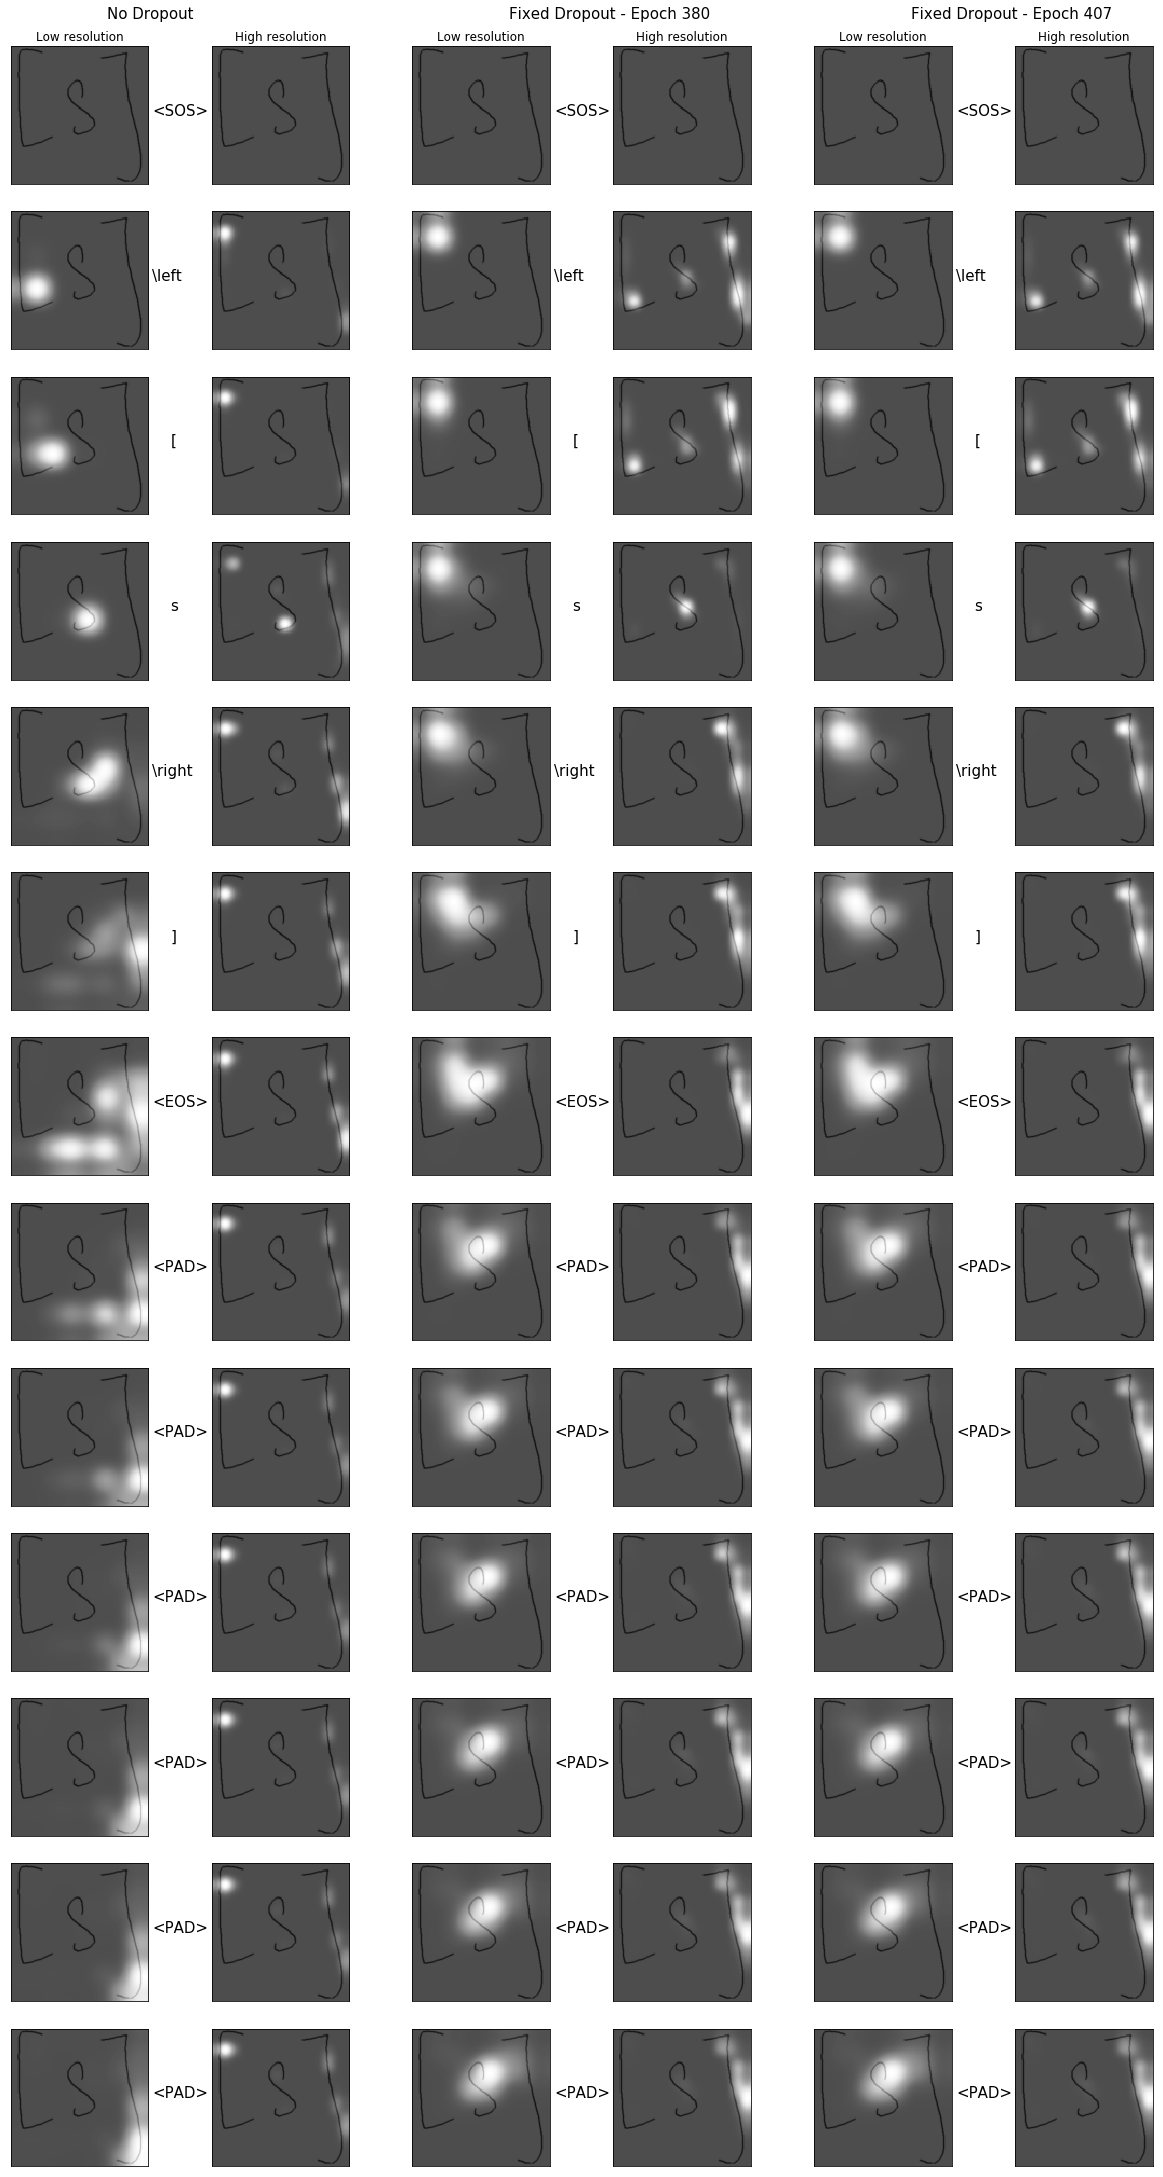

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       (`  |  `         (`  |  `                        (`  |  `                        (`  |
|          2  |  `     \pm`  |  `       \pm`  |  `                      \pm`  |  `                      \pm`  |
|          3  |  `       1`  |  `         1`  |  `                        1`  |  `                        1`  |
|          4  |  `       ,`  |  `         ,`  |  `                        ,`  |  `                        ,`  |
|          5  |  `       0`  |  `         0`  |  `                        0`  |  `                        0`  |
|          6  |  `       ,`  |  `         ,`  |  `                        ,`  |  `                        ,`  |
|          7  |  `       0`  |  `         0`  |  `                        0`  |  `                        0`  |
|          8  |  `       ,`  |  `         ,`  |  `                        ,`  |  `                        ,`  |
|          9  |  `     \pm`  |  `       \pm`  |  `                      \pm`  |  `                      \pm`  |
|         10  |  `       1`  |  `         1`  |  `                        1`  |  `                        1`  |
|         11  |  `       )`  |  `         )`  |  `                        )`  |  `                        )`  |
|         12  |  `   <EOS>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |

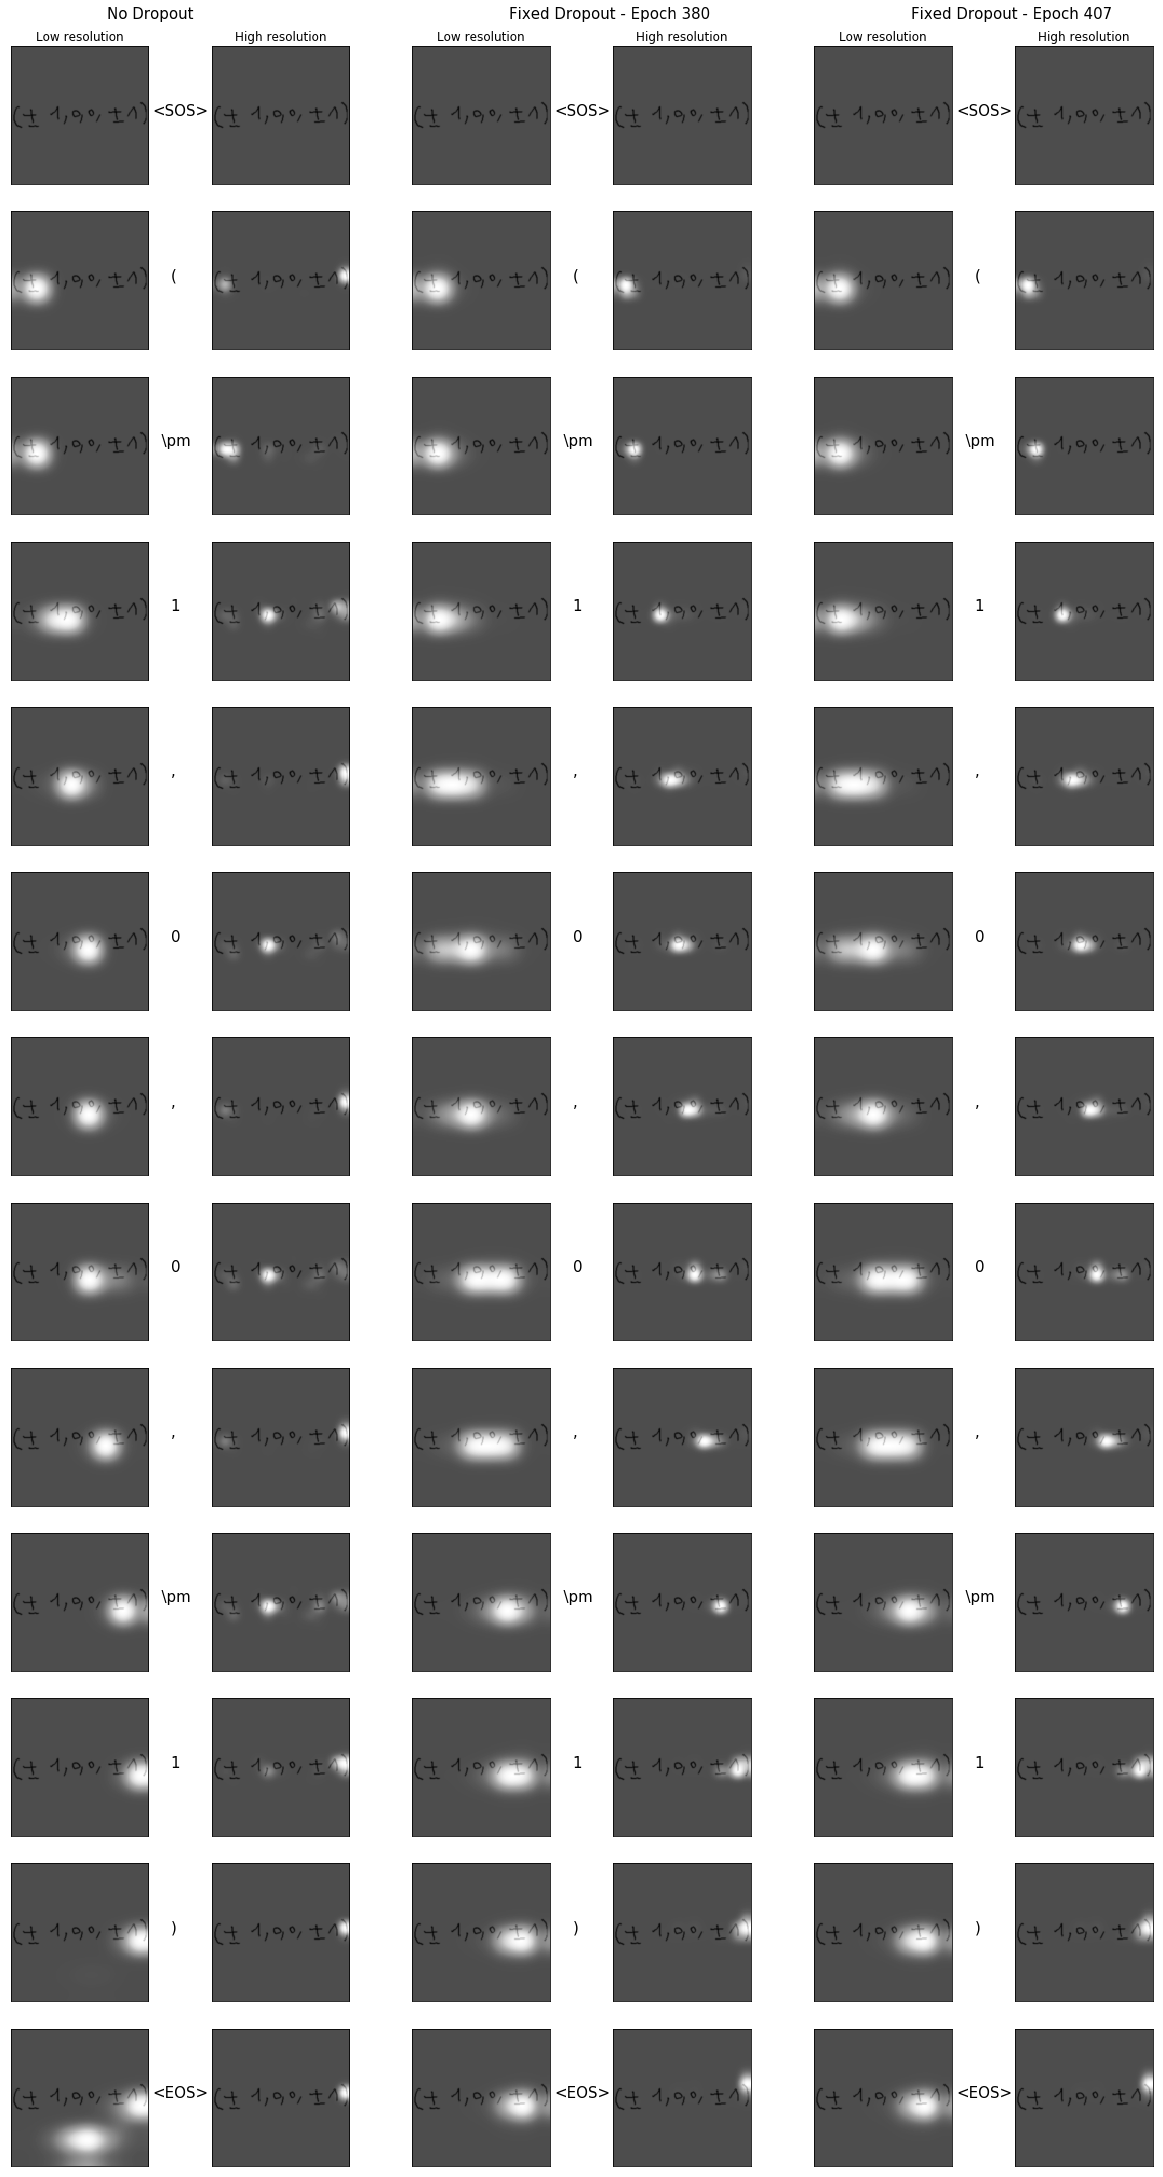

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `   \sqrt`  |  `     \sqrt`  |  `                    \sqrt`  |  `                    \sqrt`  |
|          2  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          3  |  `       l`  |  `         l`  |  `                        l`  |  `                        l`  |
|          4  |  `       }`  |  `         }`  |  `                        }`  |  `                        }`  |
|          5  |  `   <EOS>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|          6  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|          7  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|          8  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|          9  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         10  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         11  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

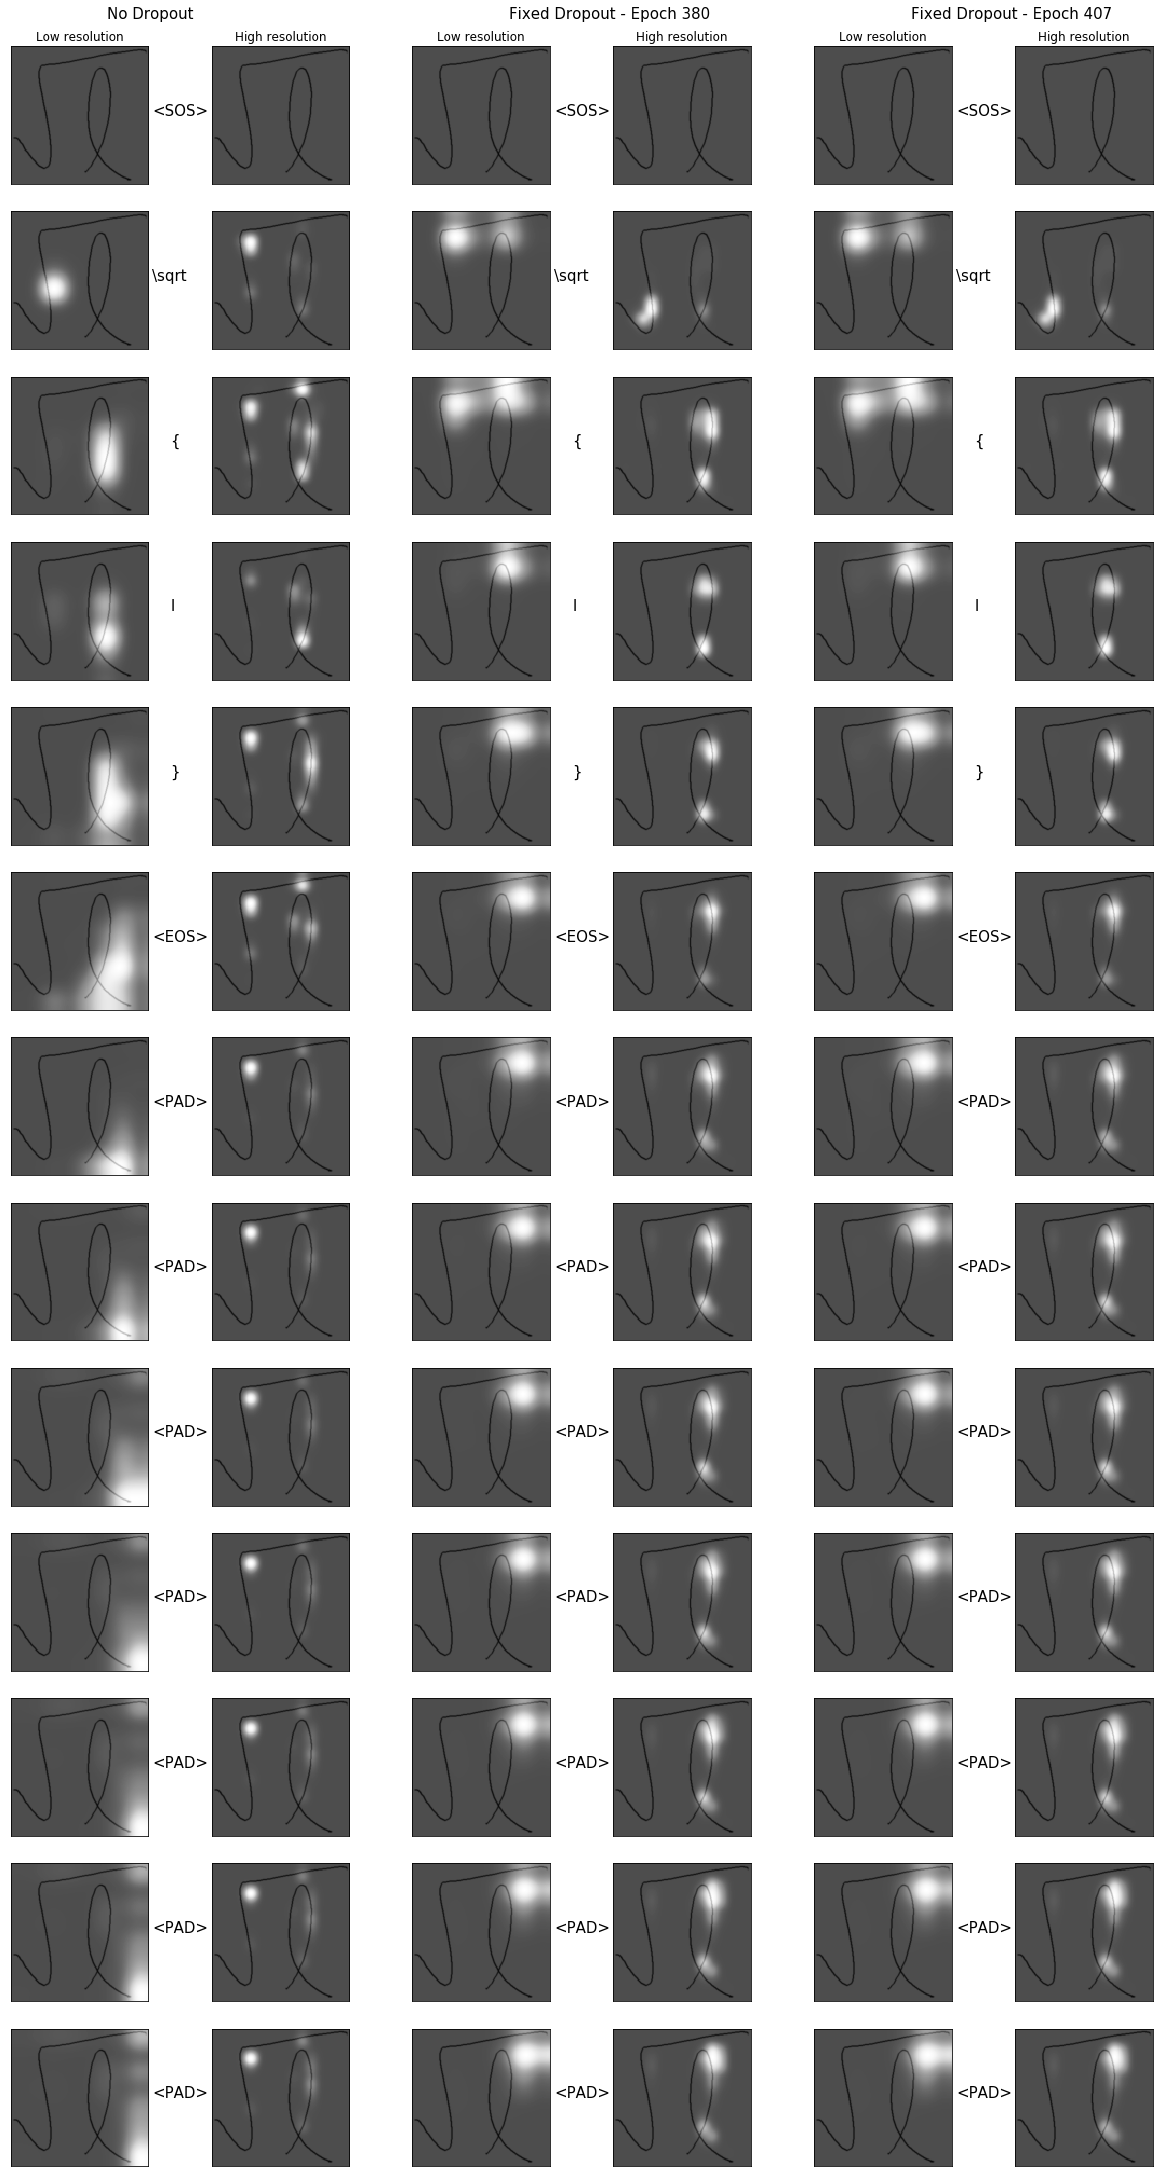

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       z`  |  `         z`  |  `                        z`  |  `                        z`  |
|          2  |  `       ^`  |  `         ^`  |  `                        ^`  |  `                        ^`  |
|          3  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          4  |  `       k`  |  `         k`  |  `                        k`  |  `                        k`  |
|          5  |  `       +`  |  `         +`  |  `                        +`  |  `                        +`  |
|          6  |  `       1`  |  `         1`  |  `                        1`  |  `                        1`  |
|          7  |  `       }`  |  `         }`  |  `                        }`  |  `                        }`  |
|          8  |  `   <EOS>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|          9  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         10  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         11  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

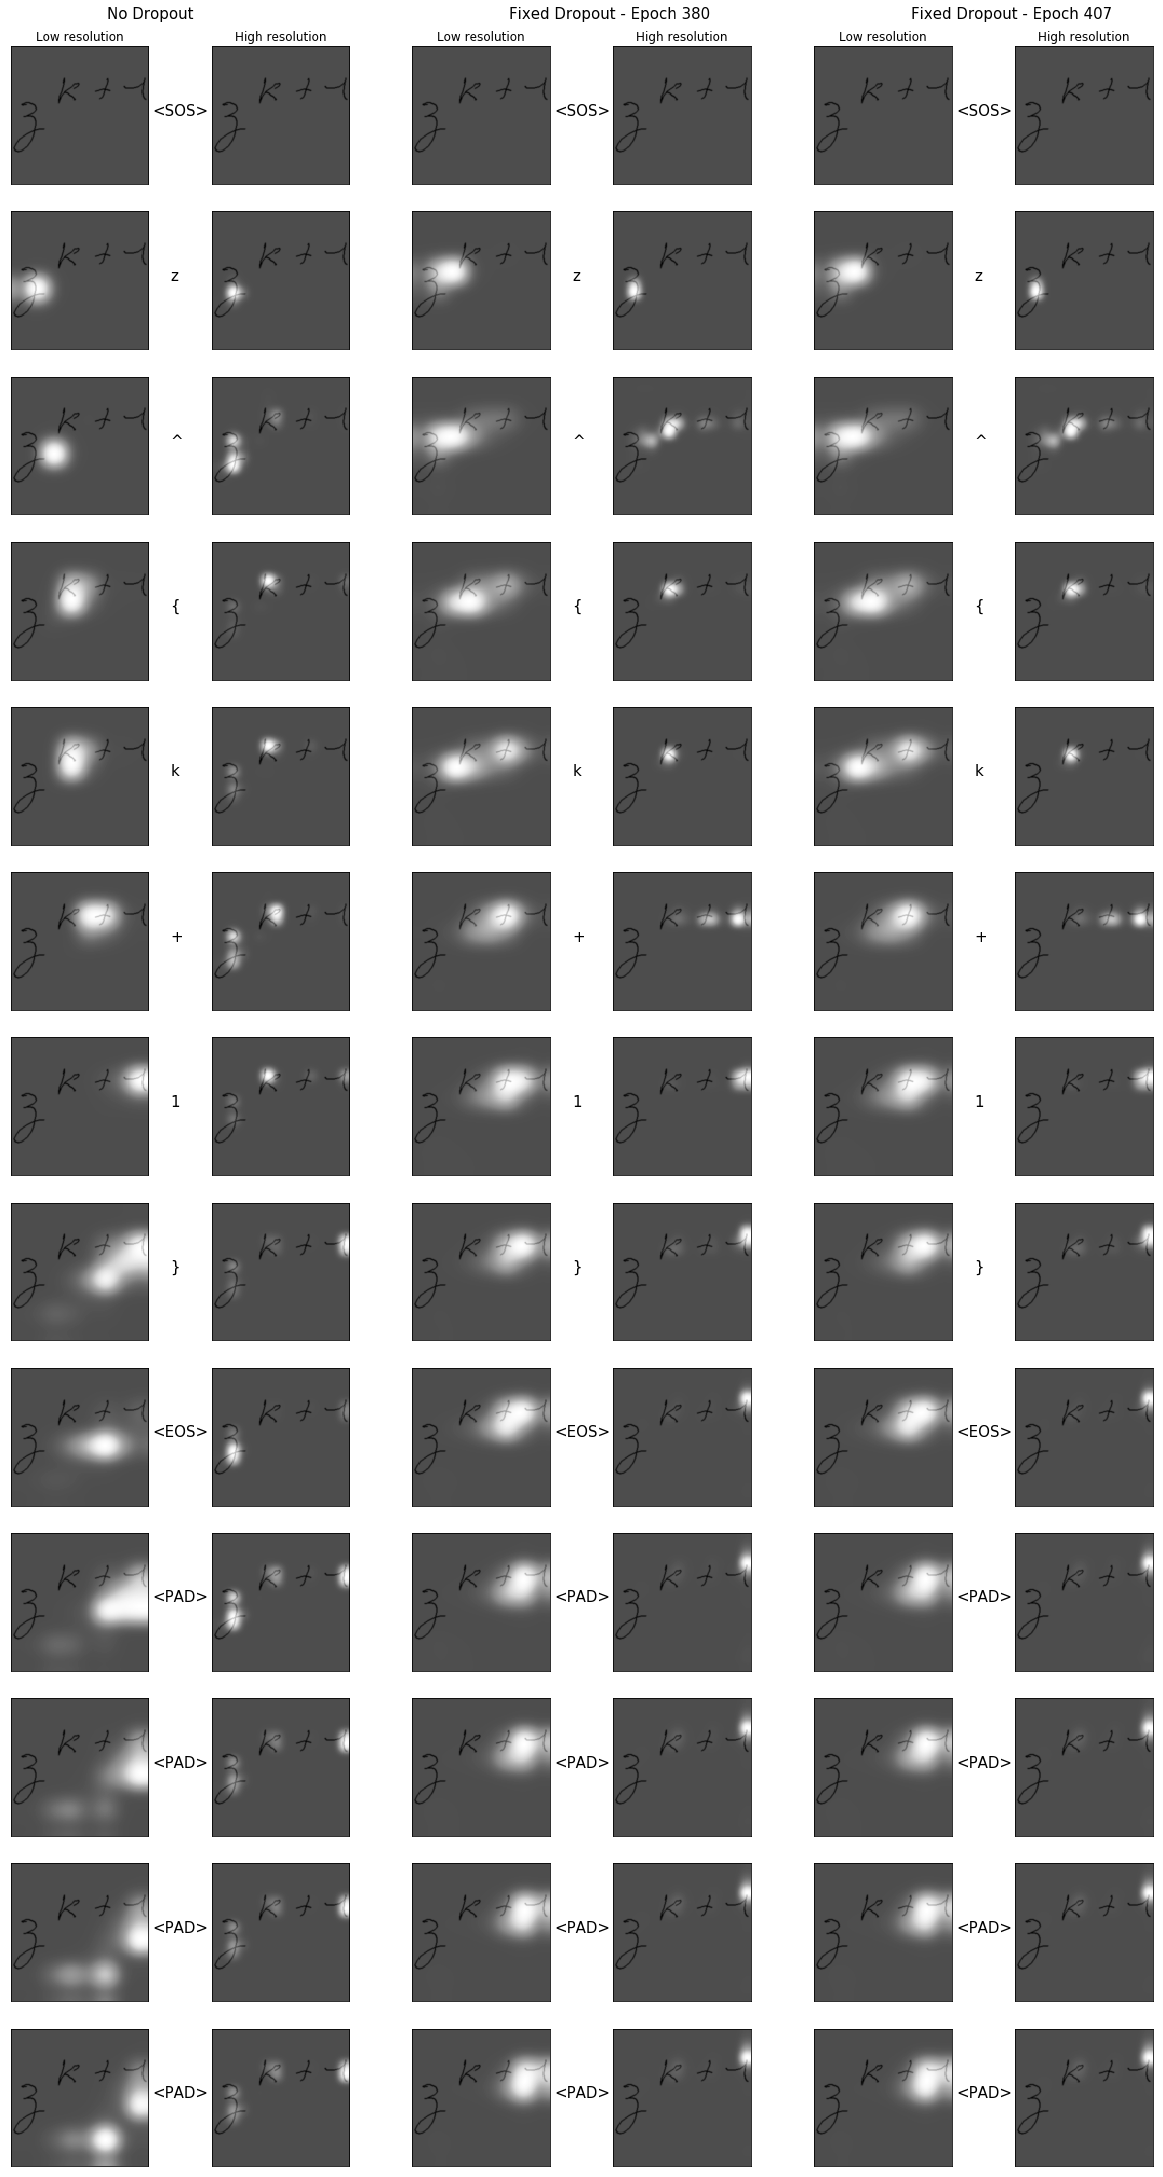

In [12]:
visualise_dataset(
    os.path.join("..", train.groundtruth),
    os.path.join("..", train.tokensfile),
    root=os.path.join("..", train.root),
)

#### Attention on test set 2013

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       d`  |  `      \phi`  |  `                        f`  |  `                        f`  |
|          2  |  `       (`  |  `         (`  |  `                        (`  |  `                        (`  |
|          3  |  `       A`  |  `         a`  |  `                        n`  |  `                        n`  |
|          4  |  `       ,`  |  `         ,`  |  `                        ,`  |  `                        ,`  |
|          5  |  `       (`  |  `     \mbox`  |  `                        (`  |  `                        (`  |
|          6  |  `       d`  |  `         {`  |  `                   \theta`  |  `                   \theta`  |
|          7  |  `       )`  |  `         a`  |  `                        )`  |  `                        )`  |
|          8  |  `       )`  |  `         }`  |  `                        )`  |  `                        )`  |
|          9  |  `       =`  |  `         )`  |  `                        =`  |  `                        =`  |
|         10  |  `       |`  |  `         =`  |  `                        (`  |  `                        (`  |
|         11  |  `       x`  |  `         (`  |  `                        2`  |  `                        b`  |
|         12  |  `       _`  |  `         a`  |  `                        k`  |  `                        k`  |
|         13  |  `       A`  |  `         -`  |  `                        -`  |  `                        -`  |
|         14  |  `       -`  |  `         x`  |  `                        a`  |  `                        a`  |
|         15  |  `       a`  |  `         )`  |  `                        )`  |  `                        )`  |
|         16  |  `       |`  |  `         (`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         17  |  `   <EOS>`  |  `         a`  |  `                    <PAD>`  |  `                    <PAD>`  |

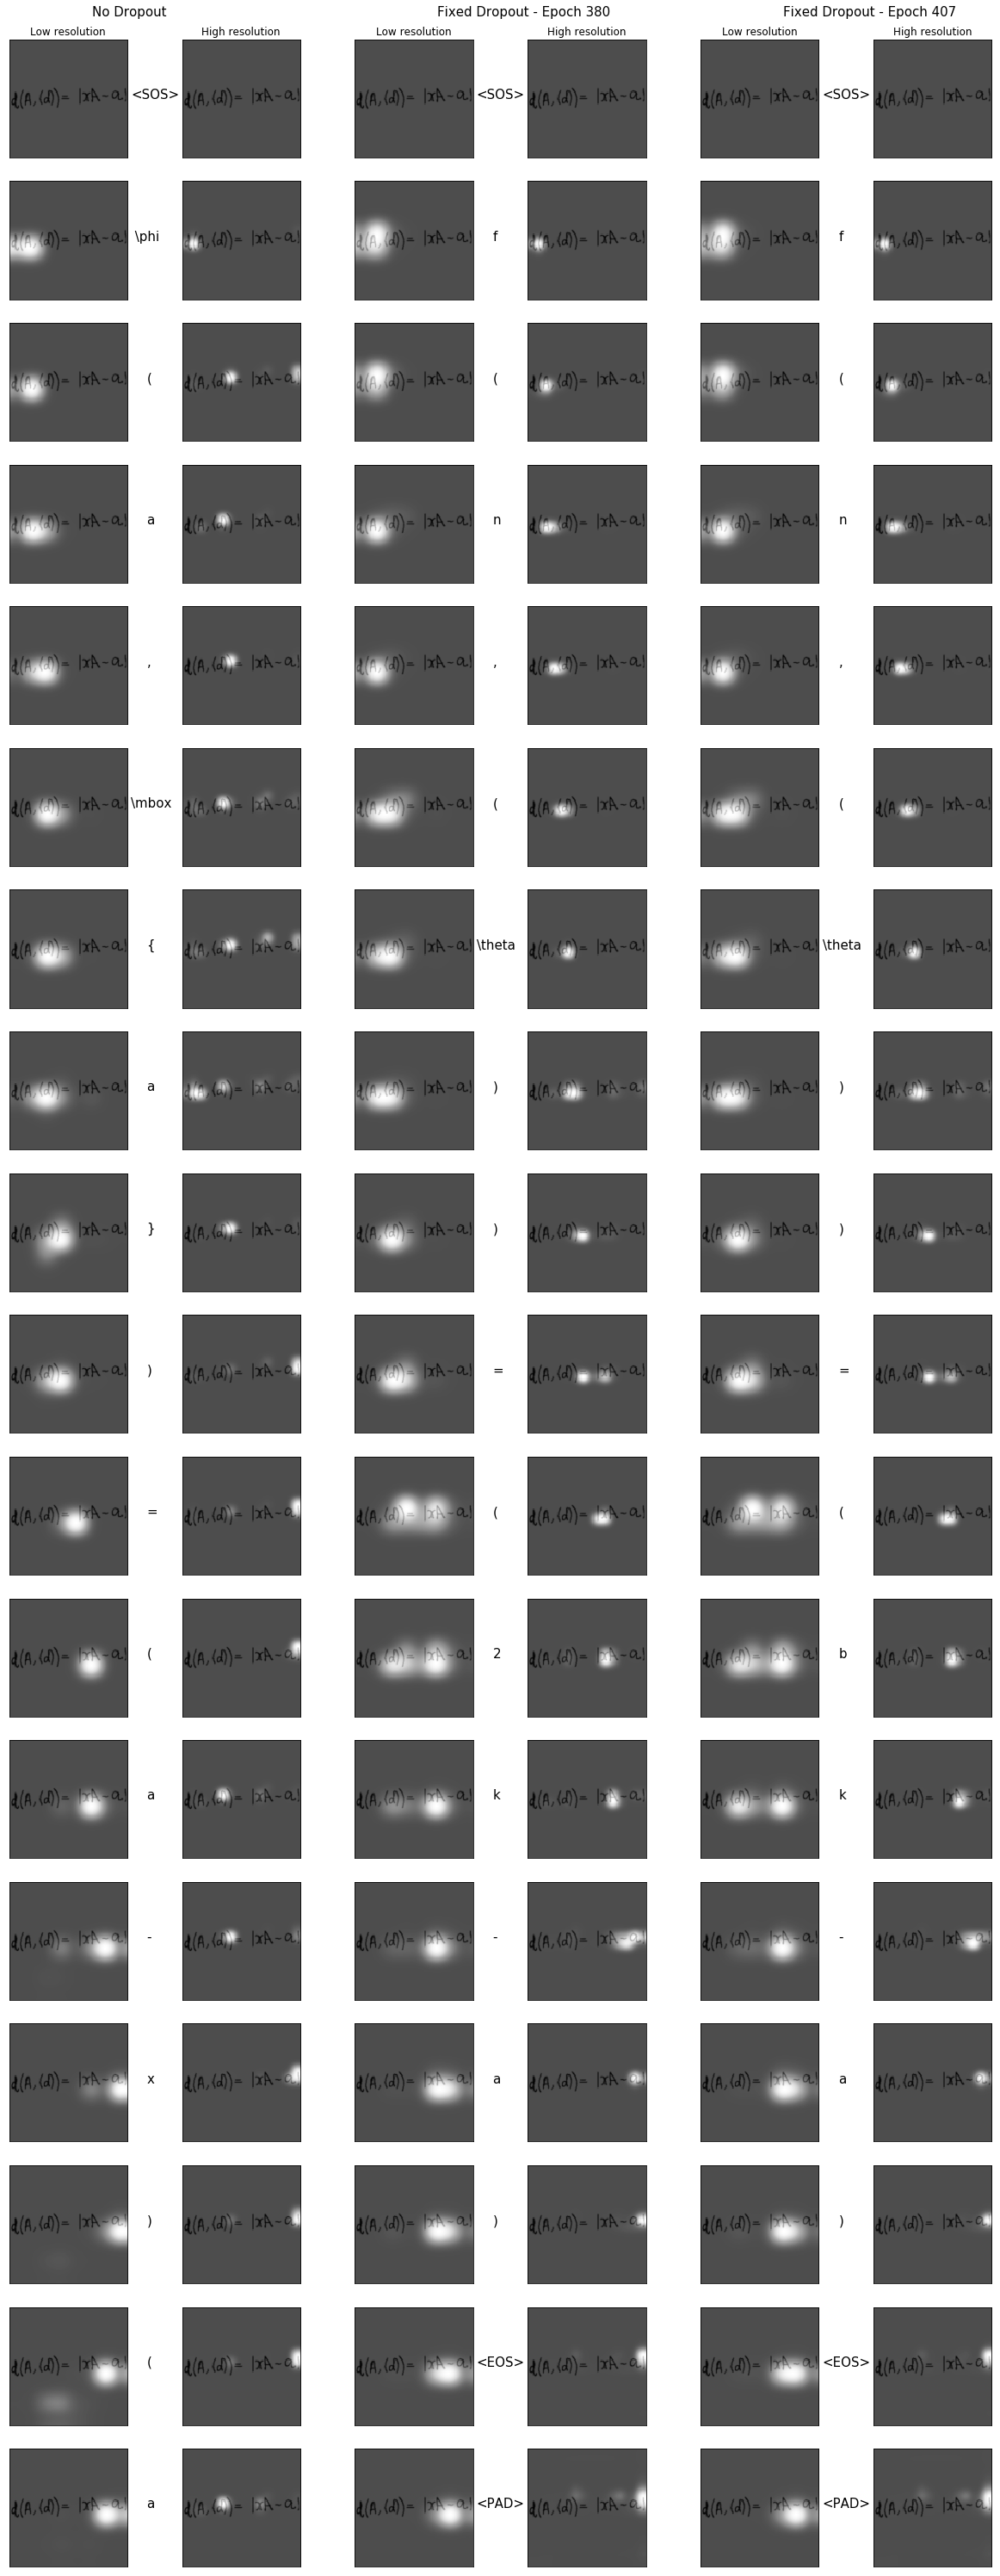

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `  \Delta`  |  `         {`  |  `                   \Delta`  |  `                   \Delta`  |
|          2  |  `       _`  |  `    \Delta`  |  `                        _`  |  `                        _`  |
|          3  |  `       r`  |  `         .`  |  `                        {`  |  `                        {`  |
|          4  |  `       G`  |  `         4`  |  `                    \mbox`  |  `                    \mbox`  |
|          5  |  `       ^`  |  `         }`  |  `                        {`  |  `                        {`  |
|          6  |  `       0`  |  `     <EOS>`  |  `                        G`  |  `                        G`  |
|          7  |  `       _`  |  `     <PAD>`  |  `                        }`  |  `                        }`  |
|          8  |  `       {`  |  `     <PAD>`  |  `                        }`  |  `                        }`  |
|          9  |  `       T`  |  `     <PAD>`  |  `                        }`  |  `                        }`  |
|         10  |  `       }`  |  `     <PAD>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         11  |  `   <EOS>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         13  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         14  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         15  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         16  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         17  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

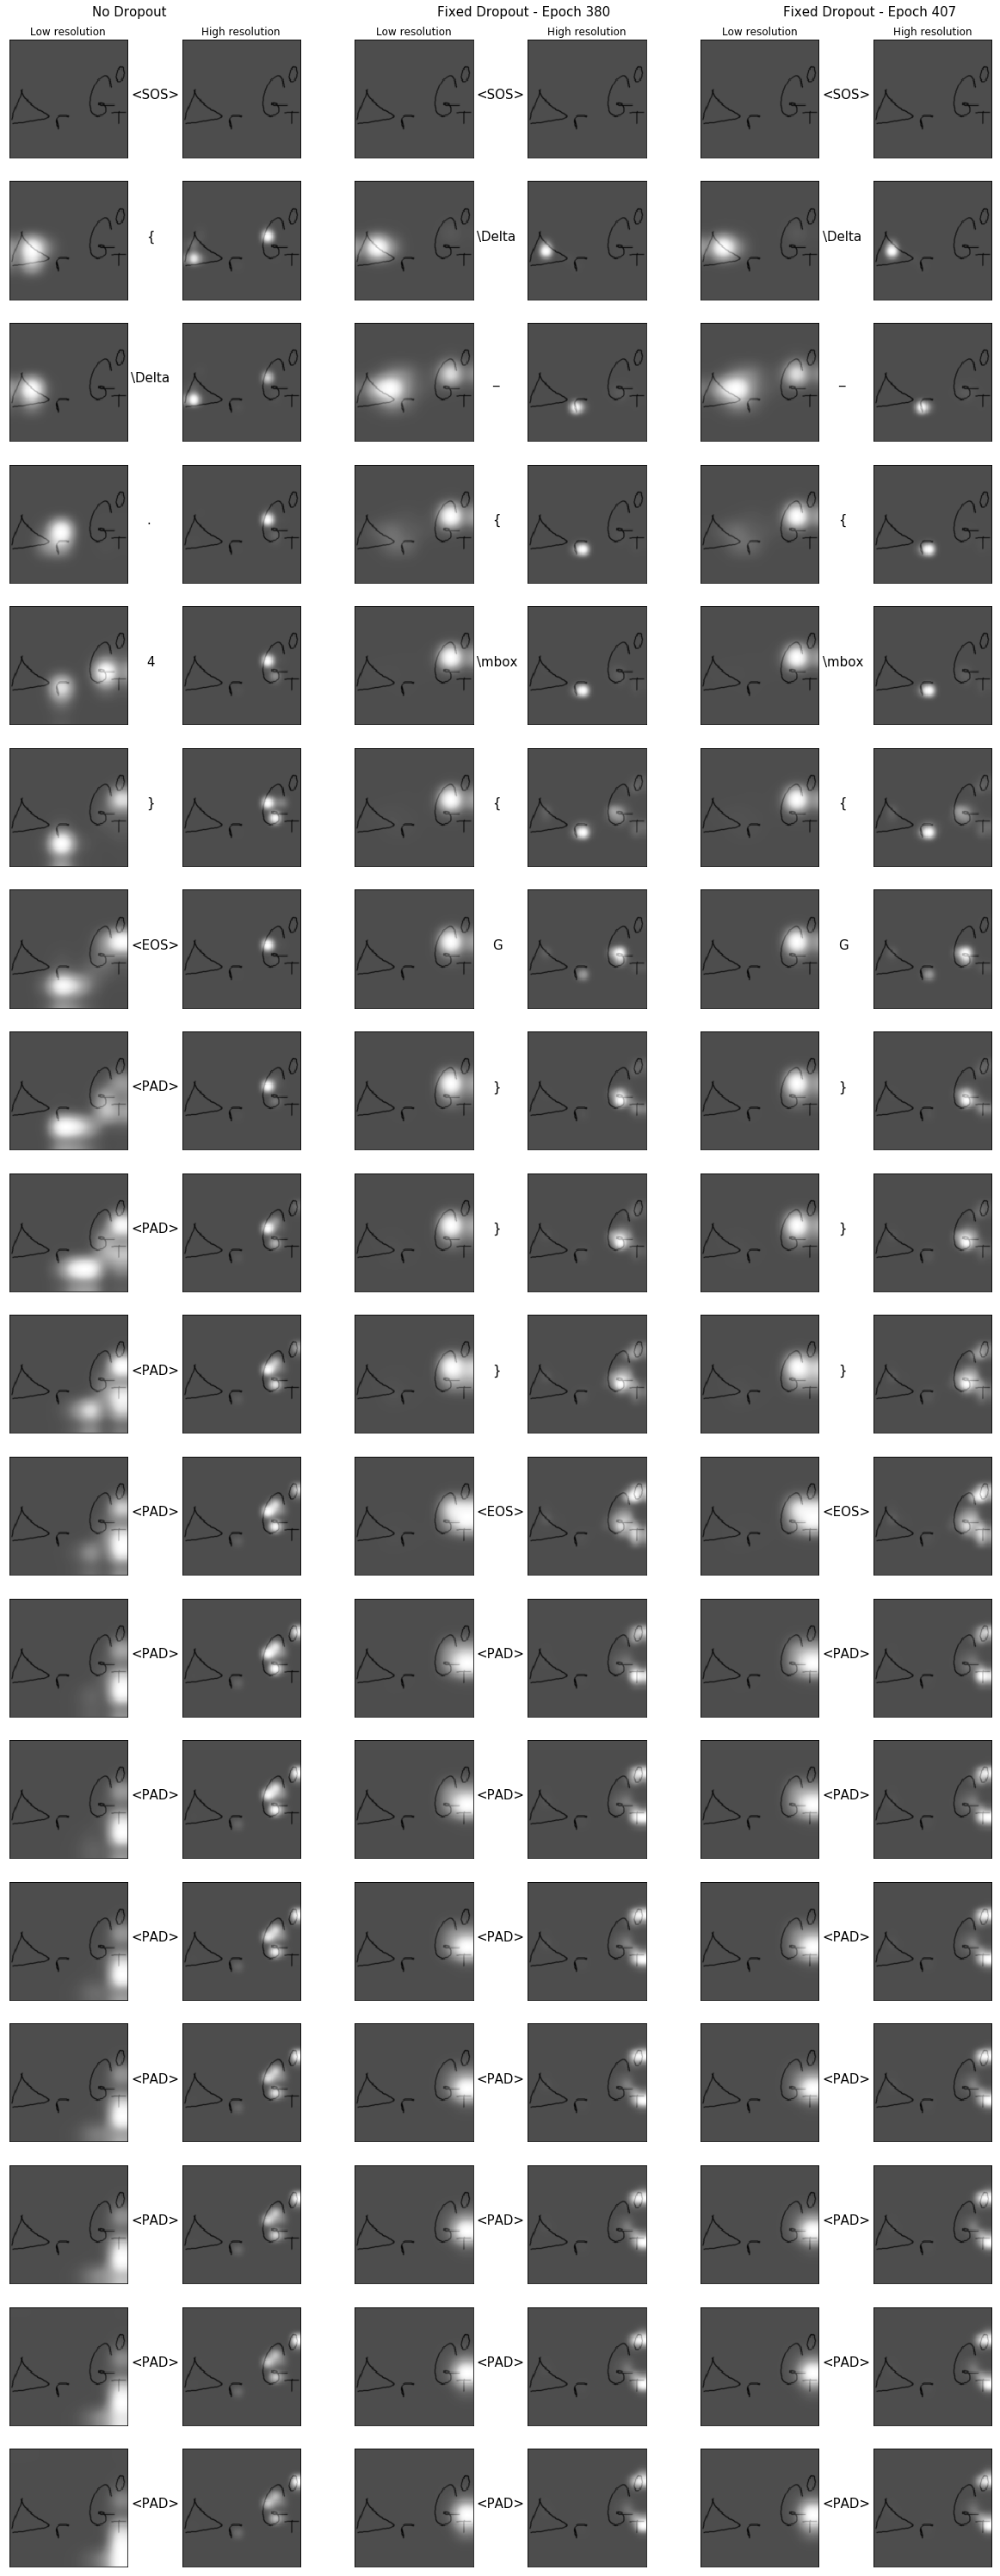

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       p`  |  `         {`  |  `                        {`  |  `                        {`  |
|          2  |  `    \neq`  |  `     \mbox`  |  `                    \mbox`  |  `                    \mbox`  |
|          3  |  `       q`  |  `         {`  |  `                     \neq`  |  `                     \neq`  |
|          4  |  `   <EOS>`  |  `         f`  |  `                        {`  |  `                        {`  |
|          5  |  `   <PAD>`  |  `         }`  |  `                        q`  |  `                        q`  |
|          6  |  `   <PAD>`  |  `      \neq`  |  `                        }`  |  `                        }`  |
|          7  |  `   <PAD>`  |  `         9`  |  `                        }`  |  `                        }`  |
|          8  |  `   <PAD>`  |  `         }`  |  `                    <EOS>`  |  `                    <EOS>`  |
|          9  |  `   <PAD>`  |  `     <EOS>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         10  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         11  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         13  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         14  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         15  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         16  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         17  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

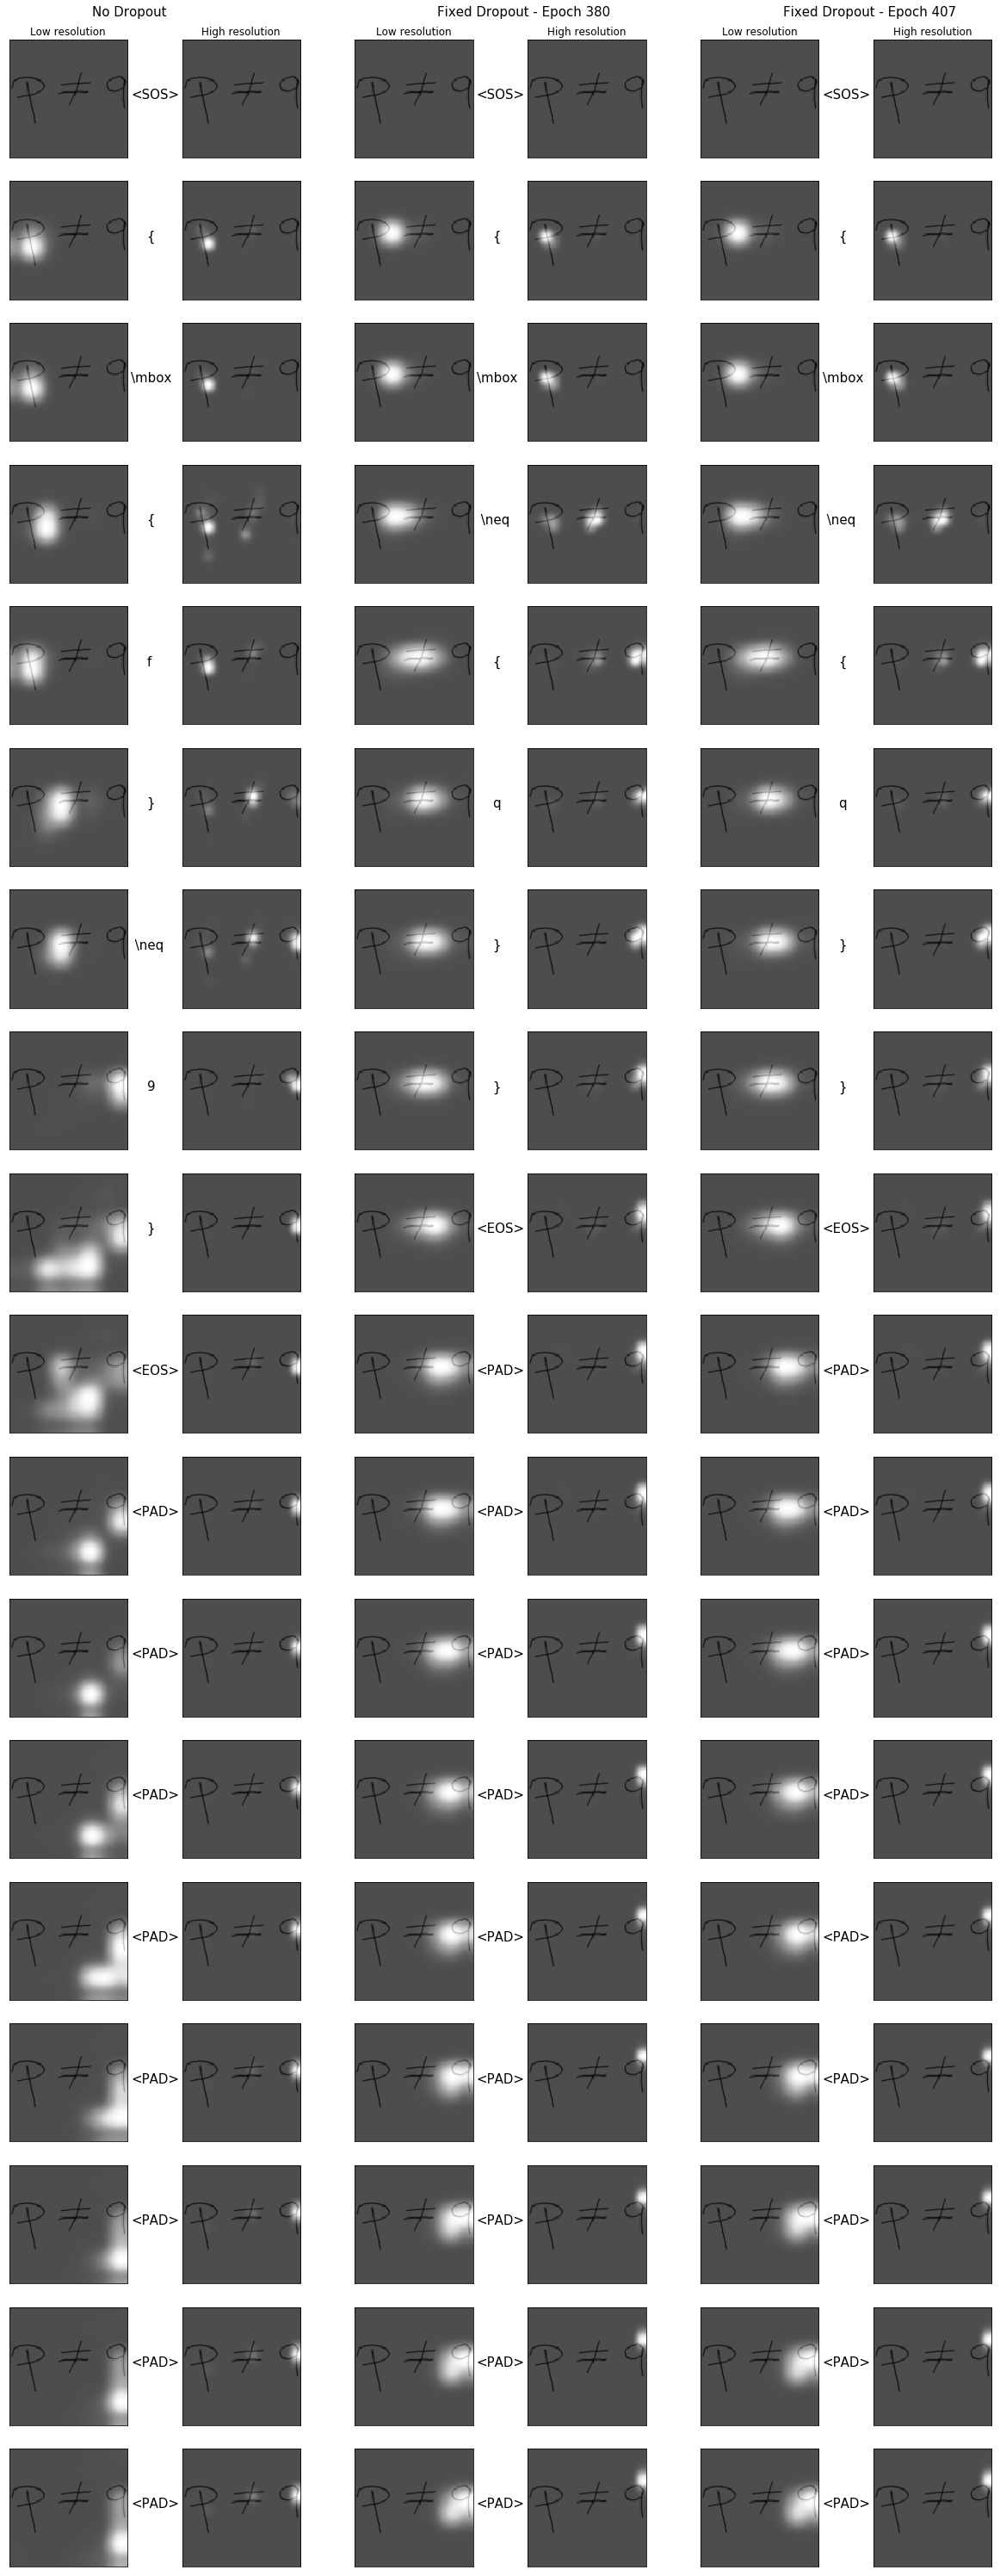

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `   \frac`  |  `     \frac`  |  `                    \frac`  |  `                    \frac`  |
|          2  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          3  |  `       h`  |  `         {`  |  `                        h`  |  `                        h`  |
|          4  |  `       -`  |  `         h`  |  `                        -`  |  `                        -`  |
|          5  |  `       y`  |  `         -`  |  `                   \gamma`  |  `                   \gamma`  |
|          6  |  `       }`  |  `     \mbox`  |  `                        }`  |  `                        }`  |
|          7  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          8  |  `       h`  |  `         h`  |  `                    \mbox`  |  `                    \mbox`  |
|          9  |  `       }`  |  `         }`  |  `                        {`  |  `                        {`  |
|         10  |  `   <EOS>`  |  `         }`  |  `                        h`  |  `                        h`  |
|         11  |  `   <PAD>`  |  `     <EOS>`  |  `                        }`  |  `                        }`  |
|         12  |  `   <PAD>`  |  `     <PAD>`  |  `                        }`  |  `                        }`  |
|         13  |  `   <PAD>`  |  `     <PAD>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         14  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         15  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         16  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         17  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

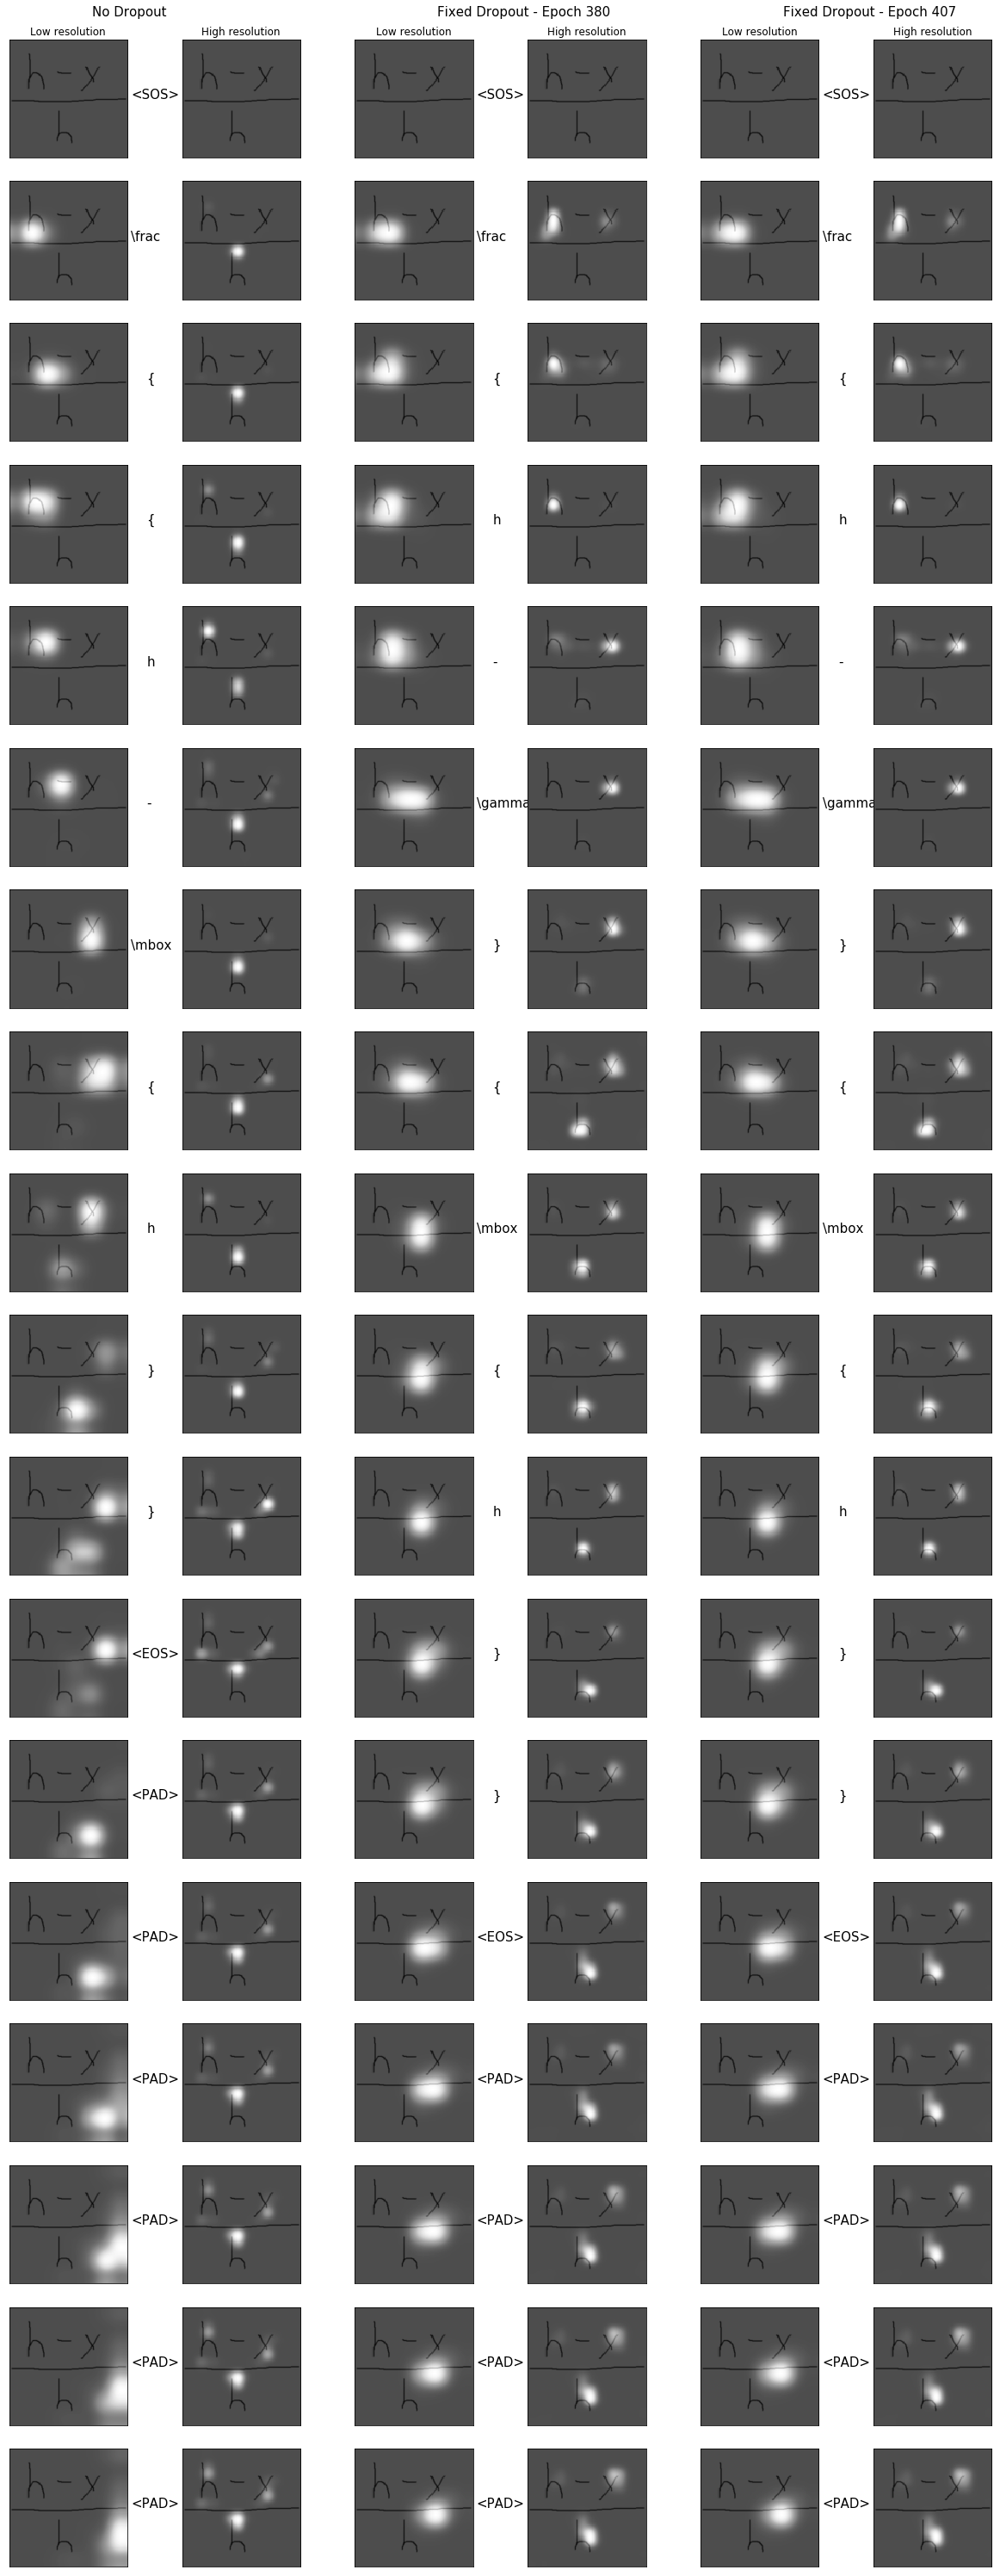

In [13]:
visualise_dataset(
    os.path.join("..", evaluate.test_sets["2013"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2013"]["root"]),
)

#### Attention on test set 2016

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       k`  |  `         k`  |  `                        k`  |  `                        k`  |
|          2  |  `       .`  |  `         (`  |  `                        x`  |  `                        x`  |
|          3  |  `       y`  |  `         t`  |  `                        +`  |  `                        +`  |
|          4  |  `       (`  |  `         ,`  |  `                        4`  |  `                        4`  |
|          5  |  `       1`  |  `         t`  |  `                        (`  |  `                        (`  |
|          6  |  `       )`  |  `         )`  |  `                        t`  |  `                        t`  |
|          7  |  `       =`  |  `         =`  |  `                        )`  |  `                        )`  |
|          8  |  `       k`  |  `         t`  |  `                        =`  |  `                        =`  |
|          9  |  `       .`  |  `         4`  |  `                        k`  |  `                        k`  |
|         10  |  `       y`  |  `         0`  |  `                        y`  |  `                        y`  |
|         11  |  `       (`  |  `     <EOS>`  |  `                        (`  |  `                        (`  |
|         12  |  `       0`  |  `     <PAD>`  |  `                        (`  |  `                        (`  |
|         13  |  `       )`  |  `     <PAD>`  |  `                        )`  |  `                        )`  |
|         14  |  `   <EOS>`  |  `     <PAD>`  |  `                        )`  |  `                        )`  |
|         15  |  `   <PAD>`  |  `     <PAD>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         16  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         17  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         18  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         19  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         20  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         21  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         22  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         23  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

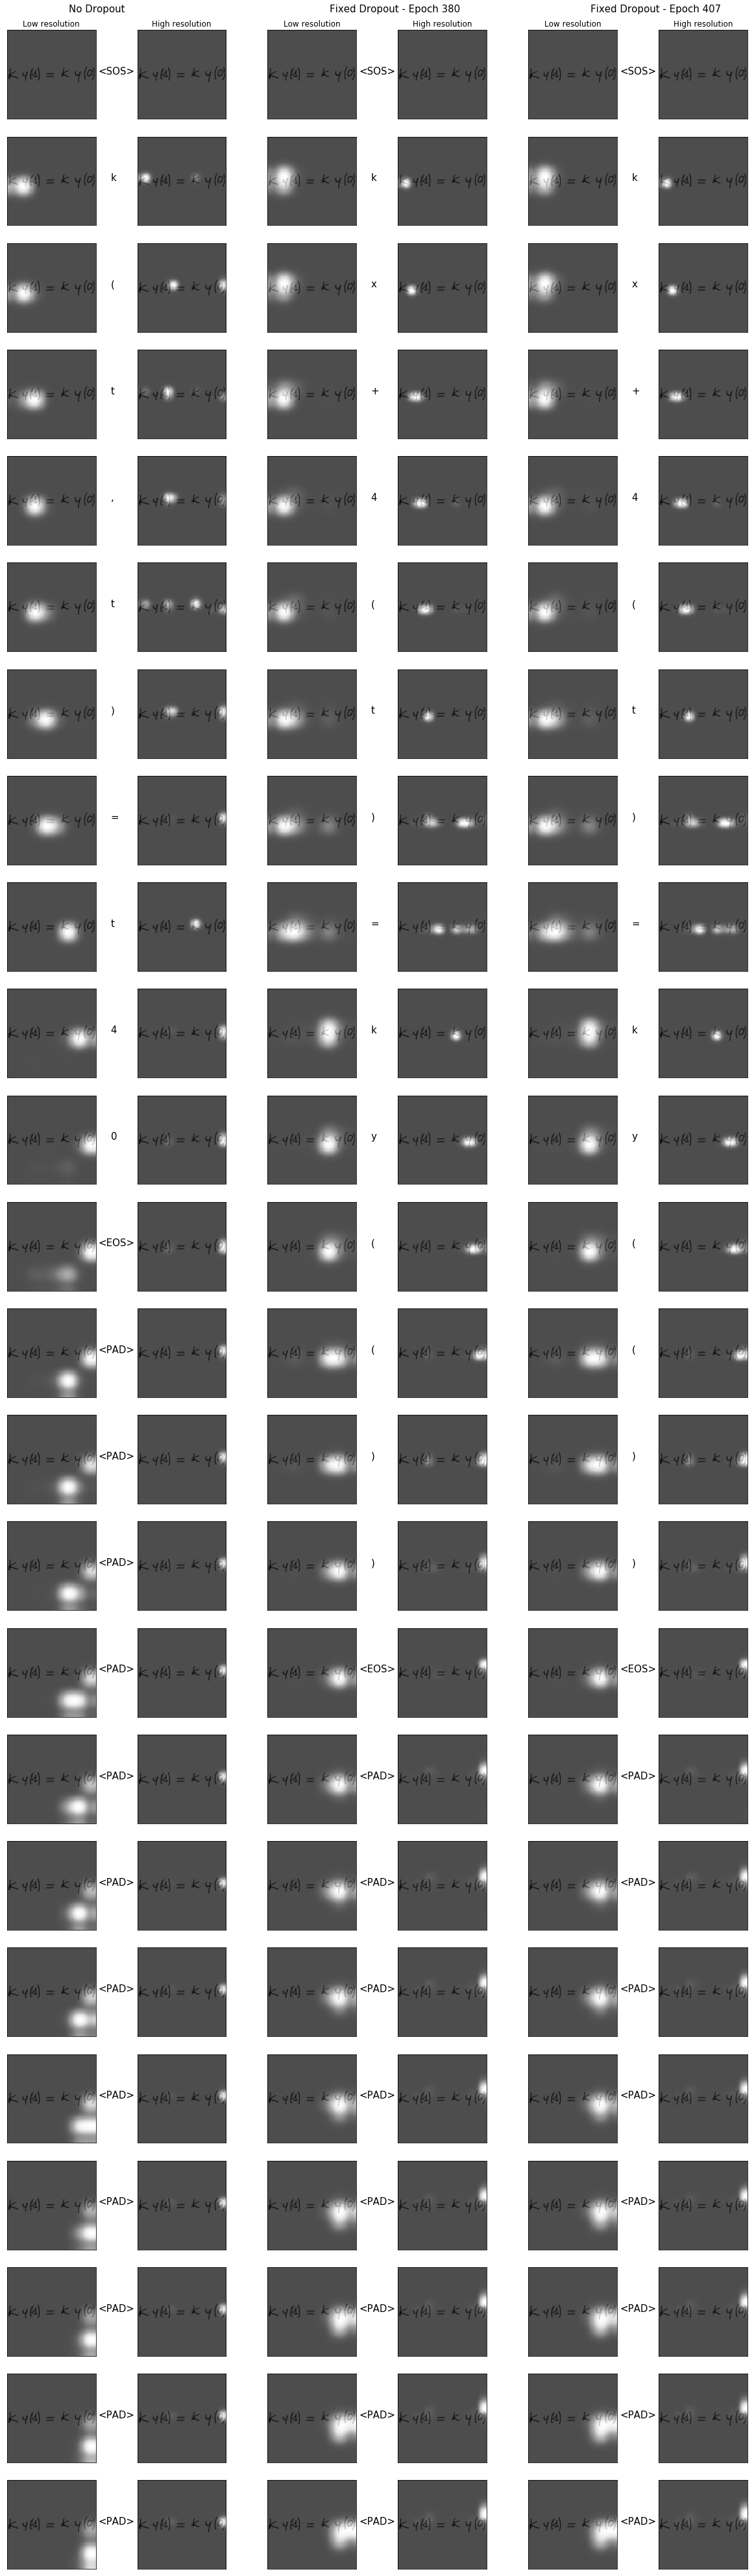

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `       -`  |  `     \frac`  |  `                        -`  |  `                        -`  |
|          2  |  `   \frac`  |  `         {`  |  `                    \frac`  |  `                    \frac`  |
|          3  |  `       {`  |  `         1`  |  `                        {`  |  `                        {`  |
|          4  |  `       1`  |  `         }`  |  `                        1`  |  `                        1`  |
|          5  |  `       }`  |  `         {`  |  `                        }`  |  `                        }`  |
|          6  |  `       {`  |  `         2`  |  `                        {`  |  `                        {`  |
|          7  |  `       2`  |  `         }`  |  `                        2`  |  `                        2`  |
|          8  |  `       4`  |  `         +`  |  `                        3`  |  `                        3`  |
|          9  |  `       }`  |  `     \frac`  |  `                        }`  |  `                        }`  |
|         10  |  `       +`  |  `         {`  |  `                        +`  |  `                        +`  |
|         11  |  `   \frac`  |  `         2`  |  `                    \frac`  |  `                    \frac`  |
|         12  |  `       {`  |  `         }`  |  `                        {`  |  `                        {`  |
|         13  |  `       a`  |  `         {`  |  `                        a`  |  `                        a`  |
|         14  |  `       }`  |  `         2`  |  `                        }`  |  `                        }`  |
|         15  |  `       {`  |  `         }`  |  `                        {`  |  `                        {`  |
|         16  |  `       4`  |  `       \pi`  |  `                        4`  |  `                        4`  |
|         17  |  `       }`  |  `     \frac`  |  `                        }`  |  `                        }`  |
|         18  |  `       (`  |  `         {`  |  `                        (`  |  `                        (`  |
|         19  |  `       1`  |  `         2`  |  `                        1`  |  `                        1`  |
|         20  |  `       -`  |  `         }`  |  `                        -`  |  `                        -`  |
|         21  |  `       a`  |  `         {`  |  `                        -`  |  `                        -`  |
|         22  |  `       )`  |  `         1`  |  `                        a`  |  `                        a`  |
|         23  |  `   <EOS>`  |  `         }`  |  `                        )`  |  `                        )`  |

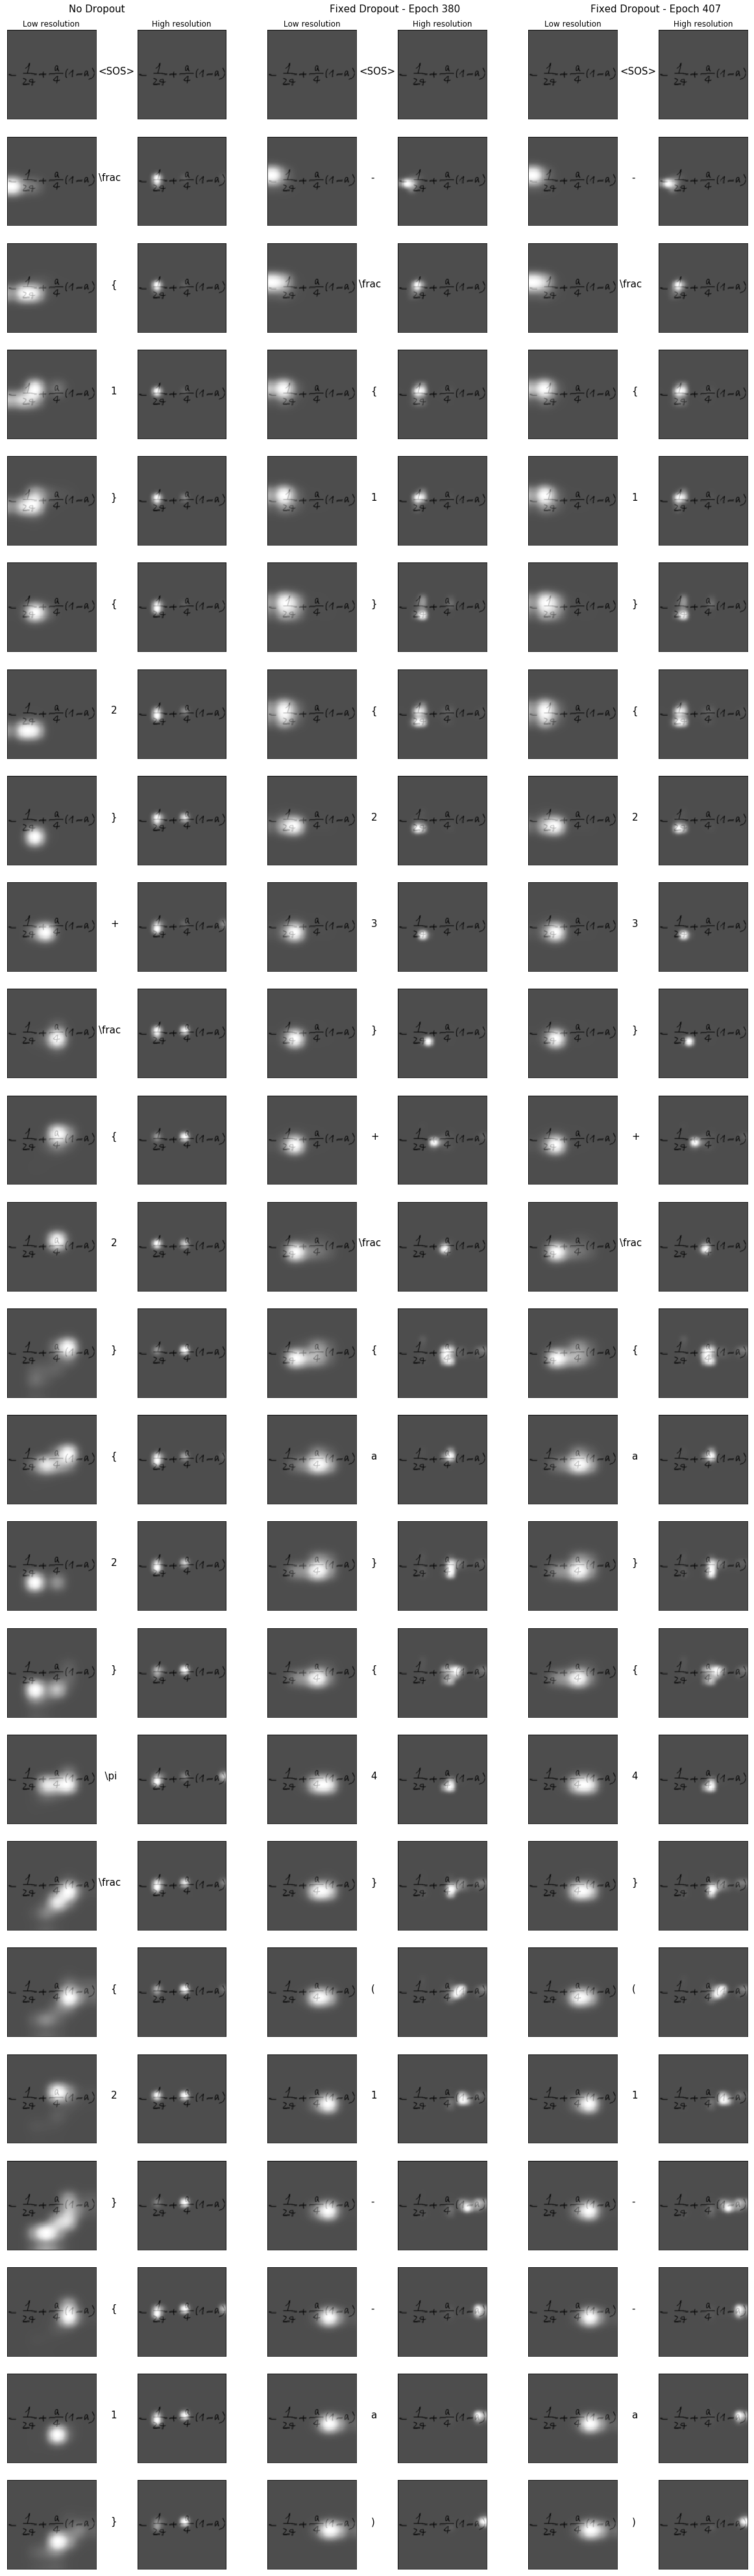

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `   \frac`  |  `     \frac`  |  `                    \frac`  |  `                    \frac`  |
|          2  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          3  |  `       3`  |  `         3`  |  `                        3`  |  `                        3`  |
|          4  |  `       k`  |  `         1`  |  `                        k`  |  `                        k`  |
|          5  |  `       }`  |  `         2`  |  `                        }`  |  `                        }`  |
|          6  |  `       {`  |  `         }`  |  `                        {`  |  `                        {`  |
|          7  |  `       k`  |  `         {`  |  `                        2`  |  `                        2`  |
|          8  |  `       +`  |  `     \mbox`  |  `                        }`  |  `                        }`  |
|          9  |  `       2`  |  `         {`  |  `                        }`  |  `                        }`  |
|         10  |  `       }`  |  `         R`  |  `                        {`  |  `                        {`  |
|         11  |  `   <EOS>`  |  `         }`  |  `                        R`  |  `                        R`  |
|         12  |  `   <PAD>`  |  `         }`  |  `                        }`  |  `                        }`  |
|         13  |  `   <PAD>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         14  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         15  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         16  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         17  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         18  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         19  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         20  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         21  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         22  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         23  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

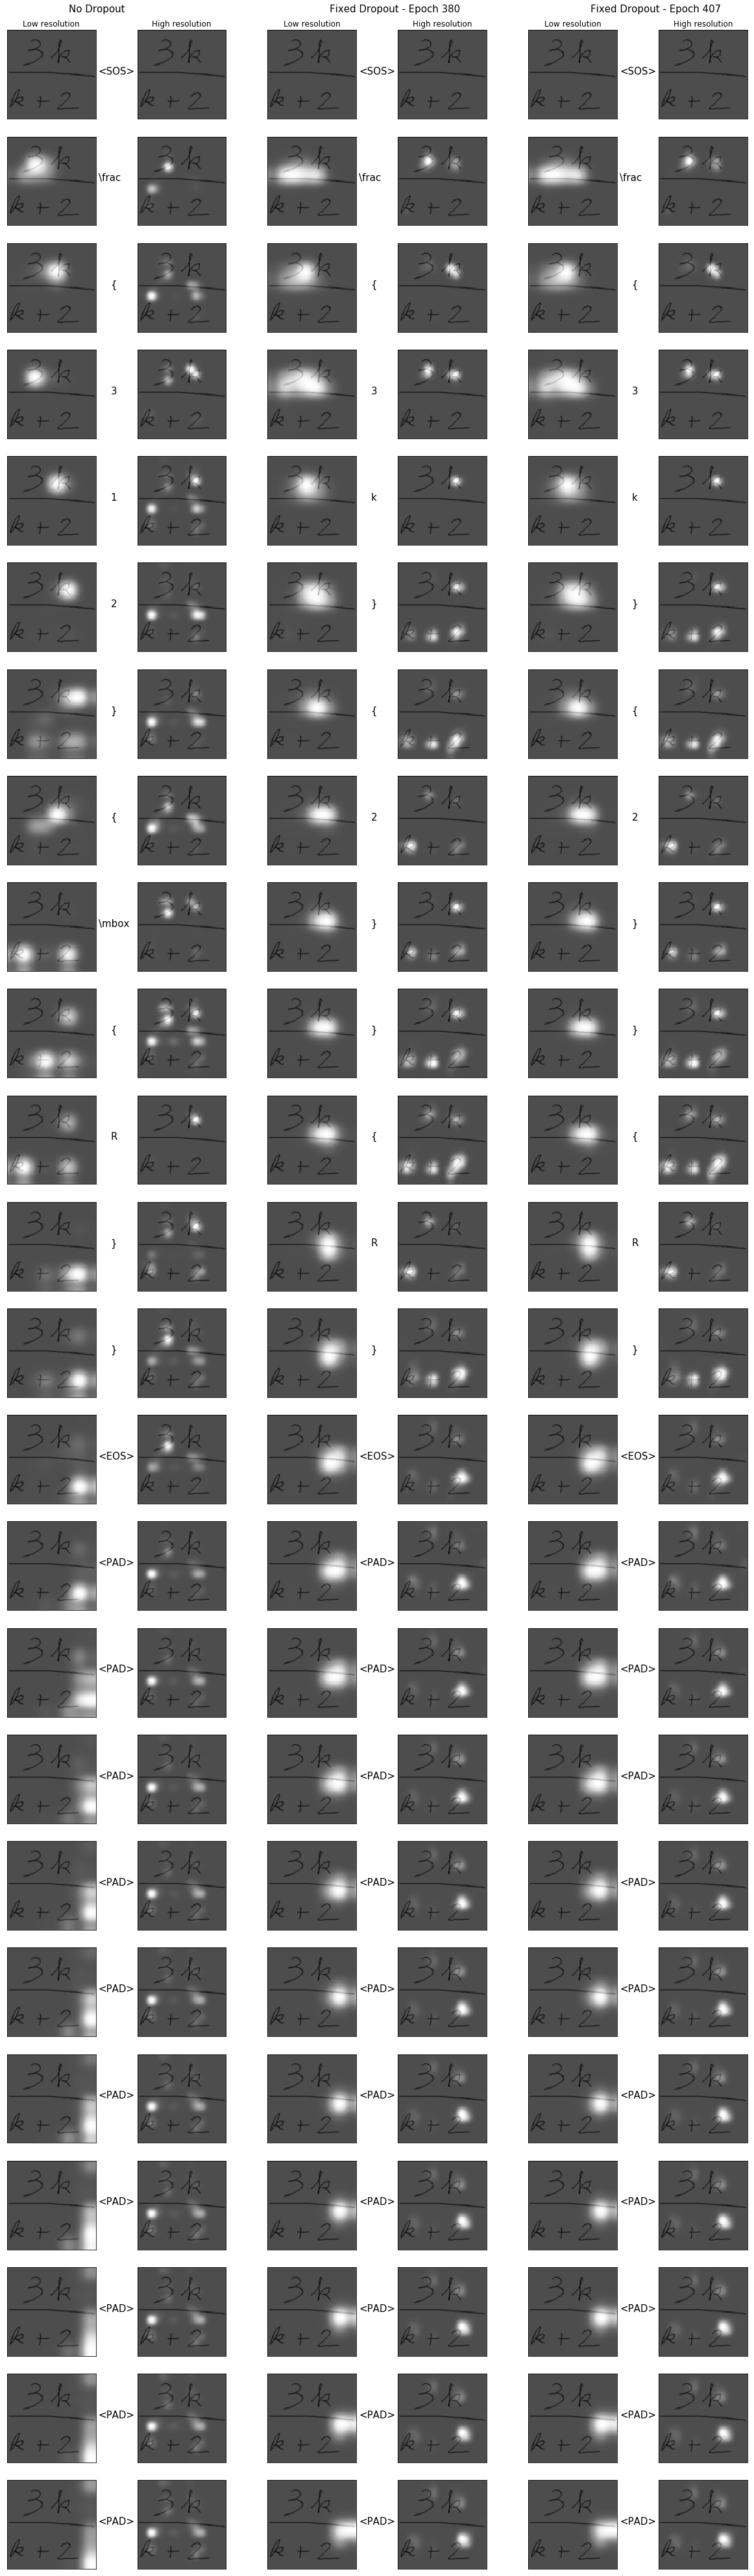

|  Time step  |  Expected  |  No Dropout  |  Fixed Dropout - Epoch 380  |  Fixed Dropout - Epoch 407  |
|-------------|------------|--------------|-----------------------------|-----------------------------|
|          0  |  `   <SOS>`  |  `     <SOS>`  |  `                    <SOS>`  |  `                    <SOS>`  |
|          1  |  `   \sqrt`  |  `     \sqrt`  |  `                    \sqrt`  |  `                    \sqrt`  |
|          2  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          3  |  `   \frac`  |  `     \frac`  |  `                    \frac`  |  `                    \frac`  |
|          4  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          5  |  `       2`  |  `         2`  |  `                        2`  |  `                        2`  |
|          6  |  `       }`  |  `         }`  |  `                        }`  |  `                        }`  |
|          7  |  `       {`  |  `         {`  |  `                        {`  |  `                        {`  |
|          8  |  `       9`  |  `     \sqrt`  |  `                    \sqrt`  |  `                    \sqrt`  |
|          9  |  `       -`  |  `         {`  |  `                        {`  |  `                        {`  |
|         10  |  `       3`  |  `         9`  |  `                        -`  |  `                        -`  |
|         11  |  `   \sqrt`  |  `         -`  |  `                        3`  |  `                        3`  |
|         12  |  `       {`  |  `         3`  |  `                    \sqrt`  |  `                    \sqrt`  |
|         13  |  `       5`  |  `     \sqrt`  |  `                        {`  |  `                        {`  |
|         14  |  `       }`  |  `         {`  |  `                        5`  |  `                        5`  |
|         15  |  `       }`  |  `         3`  |  `                        }`  |  `                        }`  |
|         16  |  `       }`  |  `         }`  |  `                        }`  |  `                        }`  |
|         17  |  `   <EOS>`  |  `         }`  |  `                        }`  |  `                        }`  |
|         18  |  `   <PAD>`  |  `     <EOS>`  |  `                    <EOS>`  |  `                    <EOS>`  |
|         19  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         20  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         21  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         22  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |
|         23  |  `   <PAD>`  |  `     <PAD>`  |  `                    <PAD>`  |  `                    <PAD>`  |

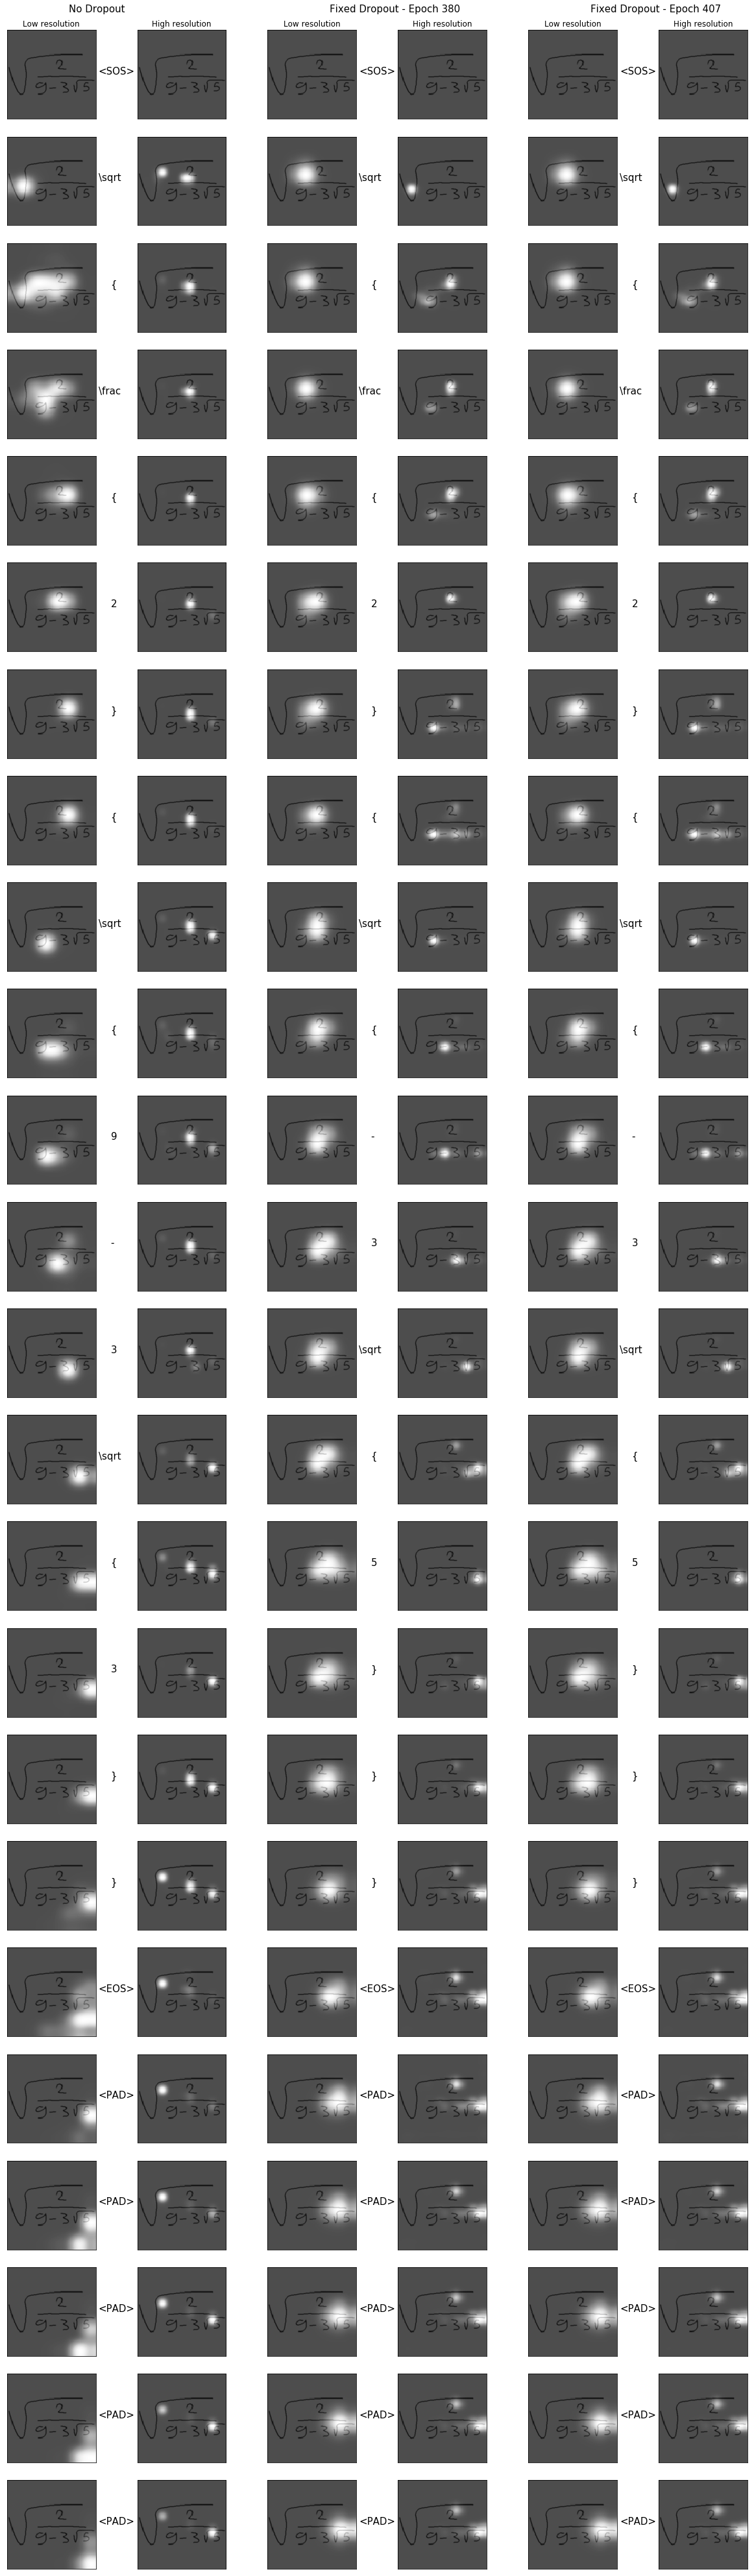

In [23]:
visualise_dataset(
    os.path.join("..", evaluate.test_sets["2016"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2016"]["root"]),
)

## Beam search

In a regular decoder a sequence is constructed by always taking the best symbol
of the current time step. It might be possible that taking a slightly worse
option at a given time, may lead to a better overall result but it would never
have been reached because it was dismissed early on, therefore it's called
a greedy algorithm. Setting the beam width to 1 is equivalent to a greedy
search.

The idea of the beam search is to keep a certain number of hypotheses at each
time step and predict the next symbol of all these hypotheses. Let's say 10
hypotheses are kept, then in the first step the 10 best predictions would be
kept, resulting in 10 different sequences. In the next step (and all future
steps) all the next symbol of all 10 of these sequences is predicted. That means
the model is run 10 times. If for each of the 10 sequences the 10 best predicted
symbols are kept, it would blow up exponentially, which makes it computationally
expensive. Because of that at only the 10 overall best hypotheses are kept. That
means there are 100 possible hypotheses, where each previous hypothesis created
10 new ones with one additional symbol, but only the 10 best of these 100 are
kept for the next step, hence the number of hypotheses remains constant.

The decoder depends on a hidden state and the attention that is accumulated in
the decoder's local state. To be able to apply beam search, these need to be
saved with the corresponding hypotheses and placed into the decoder when the
sequence is fed into it. With that it's possible to use a single decoder, but
with the appropriate states. This is straightforward for batches of size 1,
because it's just keeping track of the needed states. For batch sizes greater
than 1, it needs some extra work, because the decoder expects everything as
batched tensors, including the needed relevant states. By picking the best batch
as a hypothesis, some good sequences are lost, because a good sequence might be
part of a consistently terrible batch (that is all other sequences in the batch
score very badly and drag down score of the good sequence). To accommodate this
problem, the sequences are scored individually, therefore the batch is
disassembled and from their respective best sequences, a new batch is assembled
with the corresponding sequences being stacked on top of each other.

### Sequence comparison

In [15]:
def run_batch_beam(input, max_len, checkpoint, id_to_token, token_to_id, beam_width=10, device=device):
    enc = Encoder(img_channels=3, checkpoint=checkpoint["model"]["encoder"]).to(device)
    dec = Decoder(
        len(id_to_token),
        evaluate.low_res_shape,
        evaluate.high_res_shape,
        checkpoint=checkpoint["model"]["decoder"],
        device=device,
    ).to(device)
    enc.eval()
    dec.eval()
    
    batch_size = input.size(0)
    enc_low_res, enc_high_res = enc(input)
    dec.reset(batch_size)
    hidden = dec.init_hidden(batch_size).to(device)
    # Starts with a START token
    sequence = torch.full(
        (batch_size, 1), token_to_id[START], dtype=torch.long, device=device
    )
    hypotheses = [
        {
            "sequence": {"full": sequence},
            "hidden": hidden,
            "attn": {
                "low": dec.coverage_attn_low.alpha,
                "high": dec.coverage_attn_high.alpha,
            },
            # This will be a tensor of probabilities (one for each batch), but at
            # the beginning it can be 1.0 because it will be broadcast for the
            # multiplication and it means the first tensor of probabilities will be
            # kept as is.
            "probability": 1.0,
        }
    ]
    for i in range(max_len - 1):
        step_hypotheses = []
        for hypothesis in hypotheses:
            curr_sequence = hypothesis["sequence"]["full"]
            previous = curr_sequence[:, -1].view(-1, 1)
            curr_hidden = hypothesis["hidden"]
            # Set the attention to the corresponding values, otherwise it would use
            # the attention from another hypothesis.
            dec.coverage_attn_low.alpha = hypothesis["attn"]["low"]
            dec.coverage_attn_high.alpha = hypothesis["attn"]["high"]
            out, next_hidden = dec(previous, curr_hidden, enc_low_res, enc_high_res)
            probabilities = torch.softmax(out, dim=1)
            topk_probs, topk_ids = torch.topk(probabilities, beam_width)
            # topks are transposed, because the columns are needed, not the rows.
            # One column is the top values for the batches, and there are k rows.
            for top_prob, top_id in zip(topk_probs.t(), topk_ids.t()):
                next_sequence = torch.cat((curr_sequence, top_id.view(-1, 1)), dim=1)
                probability = hypothesis["probability"] * top_prob
                next_hypothesis = {
                    "sequence": {"full": next_sequence},
                    "hidden": next_hidden,
                    "attn": {
                        "low": dec.coverage_attn_low.alpha,
                        "high": dec.coverage_attn_high.alpha,
                    },
                    "probability": probability,
                }
                step_hypotheses.append(next_hypothesis)
        # Only the beam_width number of hypotheses with the highest probabilities
        # are kept for the next iteration.
        hypotheses = evaluate.pick_top_k_unique(step_hypotheses, beam_width)

    for hypothesis in hypotheses:
        hypothesis["decoded"] = [
            [id_to_token[tok.item()] for tok in seq]
            for seq in hypothesis["sequence"]["full"]
        ]

    return hypotheses

In [16]:
def print_sequence_table(hypotheses, expected, batch_num):
    step = "Time Step"
    exp = "Expected"
    header = "| {step} | {exp} |".format(step=step, exp=exp)
    lines = []
    pad = len(exp)
    for i in range(len(expected[batch_num])):
        line = "|  {t:>{pad_time}}  |  `{exp:>{pad_exp}}`  |".format(
            t=i, exp=expected[batch_num][i], pad_time=len(step), pad_exp=pad
        )
        for h_i in range(len(hypotheses)):
            if i == 0:
                header += "  {val:>{pad}} |".format(val=h_i + 1, pad=pad)
            # Tokens are put in a code block, because the special tokens are within
            # angle brackets and they would be treated as HTML tags in the markdown.
            line += "  `{pred:>{pad_pred}}`  |".format(
                pred=hypotheses[h_i]["decoded"][batch_num][i], pad_pred=pad
            )
        lines.append(line)

    table = "{header}\n{delimiter}\n{lines}".format(header=header, delimiter=re.sub("[^|]", "-", header), lines="\n".join(lines))
    display(Markdown(table))

In [17]:
def compare_beam_of_dataset(groundtruth, tokensfile, root=".", batch_size=1):
    batch, id_to_token, token_to_id = create_batch(groundtruth, tokensfile, batch_size=batch_size, root=root)

    input = batch["image"].to(device)
    expected = batch["truth"]["encoded"].to(device)
    expected[expected == -1] = token_to_id[PAD]
    expected_decoded = [[id_to_token[tok.item()] for tok in exp] for exp in expected]
    max_len = expected.size(1)

    hypotheses = run_batch_beam(
        input, max_len, checkpoint_fixed407, id_to_token, token_to_id, device=device
    )
    for i in range(len(expected)):
        print_sequence_table(hypotheses, expected_decoded, batch_num=i)

#### Beam of training set

In [18]:
compare_beam_of_dataset(
    os.path.join("..", evaluate.test_sets["train"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["train"]["root"]),
    batch_size=2,
)

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |
|          2  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |
|          3  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |
|          4  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |
|          5  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |
|          6  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |
|          7  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |  `       b`  |
|          8  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       3`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       b`  |
|          9  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       +`  |  `       y`  |
|         10  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       y`  |  `       +`  |
|         11  |  `       c`  |  `       c`  |  `       y`  |  `       c`  |  `       c`  |  `       c`  |  `       c`  |  `       g`  |  `       +`  |  `       y`  |  `       c`  |
|         12  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       y`  |  `       ^`  |  `       y`  |
|         13  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       c`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       2`  |  `       ^`  |
|         14  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |  `       ^`  |  `       3`  |  `       2`  |  `       2`  |  `   <EOS>`  |  `       2`  |
|         15  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `       2`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |  `    \sum`  |
|          2  |  `       {`  |  `    \phi`  |  `       {`  |  `    \phi`  |  `       {`  |  `    \phi`  |  `    \phi`  |  `       {`  |  `    \phi`  |  `    \phi`  |  `    \phi`  |
|          3  |  `    \phi`  |  `   <EOS>`  |  `    \phi`  |  `   <EOS>`  |  `    \phi`  |  `   <EOS>`  |  `   <EOS>`  |  `    \phi`  |  `       }`  |  `    \phi`  |  `   <EOS>`  |
|          4  |  `       }`  |  `   <PAD>`  |  `       }`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `    \phi`  |  `       }`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |
|          5  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|          6  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |
|          7  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|          8  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|          9  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         10  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         11  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         12  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         13  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         14  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         15  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

#### Beam of test set 2013

In [19]:
compare_beam_of_dataset(
    os.path.join("..", evaluate.test_sets["2013"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2013"]["root"]),
    batch_size=2,
)

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `    \cos`  |  `    \cos`  |  `       c`  |  `       c`  |  `       c`  |  `       c`  |  `       c`  |  `    \cos`  |  `       c`  |  `    \cos`  |  `    \cos`  |
|          2  |  `       x`  |  `       x`  |  `    \cos`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       {`  |  `       0`  |  `       X`  |  `       x`  |
|          3  |  `       +`  |  `       +`  |  `       x`  |  `  \times`  |  `       5`  |  `   \cdot`  |  `       5`  |  `       o`  |  `       5`  |  `       +`  |  `       +`  |
|          4  |  `       1`  |  `       1`  |  `       +`  |  `       x`  |  `       X`  |  `       x`  |  `  \times`  |  `       }`  |  `       x`  |  `       1`  |  `       1`  |
|          5  |  `   <EOS>`  |  `   <EOS>`  |  `       1`  |  `       +`  |  `       +`  |  `       +`  |  `       1`  |  `       +`  |  `       +`  |  `   <EOS>`  |  `   <EOS>`  |
|          6  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `       1`  |  `       1`  |  `       1`  |  `   <EOS>`  |  `       1`  |  `       1`  |  `   <PAD>`  |  `   <EOS>`  |
|          7  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |
|          8  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|          9  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         10  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         11  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         12  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         13  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         14  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         15  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         16  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         17  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         18  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         19  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         20  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         21  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         22  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         23  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         24  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         25  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         26  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `       T`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |  `     \pi`  |
|          2  |  `       _`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |  `    \sin`  |
|          3  |  `       {`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `   \left`  |  `       (`  |  `       (`  |  `       (`  |
|          4  |  `       n`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |  `       (`  |  `       x`  |  `       x`  |  `       x`  |
|          5  |  `       }`  |  `  \right`  |  `  \right`  |  `       (`  |  `  \right`  |  `   \left`  |  `  \right`  |  `       x`  |  `  \right`  |  `  \right`  |  `       (`  |
|          6  |  `       (`  |  `       )`  |  `       )`  |  `       x`  |  `       (`  |  `       (`  |  `       )`  |  `  \right`  |  `       )`  |  `       (`  |  `       x`  |
|          7  |  `       T`  |  `       (`  |  `       (`  |  `       )`  |  `       x`  |  `       x`  |  `       (`  |  `       )`  |  `       (`  |  `       x`  |  `       )`  |
|          8  |  `       _`  |  `       x`  |  `       x`  |  `       =`  |  `       )`  |  `       )`  |  `       x`  |  `       )`  |  `       x`  |  `       )`  |  `       =`  |
|          9  |  `       {`  |  `       )`  |  `       )`  |  `    \tan`  |  `       =`  |  `       =`  |  `       )`  |  `       =`  |  `       )`  |  `       =`  |  `    \tan`  |
|         10  |  `       m`  |  `       =`  |  `       =`  |  `       (`  |  `    \tan`  |  `    \tan`  |  `       =`  |  `    \tan`  |  `       =`  |  `       F`  |  `       (`  |
|         11  |  `       }`  |  `    \tan`  |  `       F`  |  `       x`  |  `       (`  |  `       (`  |  `    \tan`  |  `       (`  |  `       F`  |  `       (`  |  `       x`  |
|         12  |  `       (`  |  `       (`  |  `       (`  |  `       )`  |  `       x`  |  `       x`  |  `       (`  |  `       x`  |  `       (`  |  `       x`  |  `       )`  |
|         13  |  `       X`  |  `       x`  |  `       x`  |  `   <EOS>`  |  `       )`  |  `       )`  |  `       x`  |  `       )`  |  `       x`  |  `       )`  |  `       )`  |
|         14  |  `       )`  |  `       )`  |  `       )`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `  \right`  |  `   <EOS>`  |  `       )`  |  `       )`  |  `       =`  |
|         15  |  `       )`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `       )`  |  `   <PAD>`  |  `       )`  |  `   <EOS>`  |  `       F`  |
|         16  |  `       =`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `       (`  |
|         17  |  `       T`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `       x`  |
|         18  |  `       _`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `       )`  |
|         19  |  `       {`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |
|         20  |  `       m`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         21  |  `       n`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         22  |  `       }`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         23  |  `       (`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         24  |  `       X`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         25  |  `       )`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         26  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

#### Beam of test set 2014

In [26]:
compare_beam_of_dataset(
    os.path.join("..", evaluate.test_sets["2014"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2014"]["root"]),
    batch_size=2,
)

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `   \beta`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |  `       r`  |
|          2  |  `       _`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |
|          3  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |  `       0`  |
|          4  |  `       (`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |
|          5  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |
|          6  |  `       )`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |  `       2`  |  `       5`  |
|          7  |  `       +`  |  `       5`  |  `       5`  |  `       5`  |  `       /`  |  `       /`  |  `       /`  |  `       5`  |  `       5`  |  `       5`  |  `       5`  |
|          8  |  `   \beta`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |
|          9  |  `       _`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |  `       4`  |
|         10  |  `       1`  |  `       )`  |  `       )`  |  `       )`  |  `       3`  |  `       3`  |  `       3`  |  `       )`  |  `       )`  |  `       )`  |  `       )`  |
|         11  |  `       (`  |  `       +`  |  `       +`  |  `       +`  |  `       )`  |  `       )`  |  `       )`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |
|         12  |  `       i`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |  `       +`  |
|         13  |  `       )`  |  `       2`  |  `       2`  |  `       2`  |  `       +`  |  `       +`  |  `       +`  |  `       2`  |  `       2`  |  `       2`  |  `       2`  |
|         14  |  `       +`  |  `       6`  |  `       6`  |  `       6`  |  `       2`  |  `       2`  |  `       2`  |  `       6`  |  `       6`  |  `       6`  |  `       6`  |
|         15  |  `   \beta`  |  `       )`  |  `       )`  |  `       )`  |  `       6`  |  `       6`  |  `       6`  |  `       )`  |  `       )`  |  `       )`  |  `       )`  |
|         16  |  `       _`  |  `       /`  |  `       /`  |  `       /`  |  `       )`  |  `       )`  |  `       )`  |  `       /`  |  `       /`  |  `       /`  |  `       /`  |
|         17  |  `       2`  |  `       (`  |  `       (`  |  `       (`  |  `       /`  |  `       /`  |  `       /`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |
|         18  |  `       (`  |  `       6`  |  `       6`  |  `       2`  |  `       (`  |  `       (`  |  `       (`  |  `       6`  |  `       6`  |  `       6`  |  `       6`  |
|         19  |  `       j`  |  `       3`  |  `       3`  |  `       3`  |  `       6`  |  `       6`  |  `       6`  |  `       3`  |  `       3`  |  `       3`  |  `       3`  |
|         20  |  `       )`  |  `  \times`  |  `  \times`  |  `  \times`  |  `       3`  |  `       3`  |  `       3`  |  `       )`  |  `       )`  |  `       )`  |  `       )`  |
|         21  |  `       +`  |  `       (`  |  `       (`  |  `       (`  |  `  \times`  |  `  \times`  |  `  \times`  |  `  \times`  |  `  \times`  |  `  \times`  |  `       /`  |
|         22  |  `   \beta`  |  `       3`  |  `       4`  |  `       4`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |  `       (`  |
|         23  |  `       _`  |  `       )`  |  `       )`  |  `       )`  |  `       3`  |  `       4`  |  `       )`  |  `       4`  |  `       3`  |  `       4`  |  `       4`  |
|         24  |  `       3`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `       )`  |  `       )`  |  `   <EOS>`  |  `       )`  |  `       )`  |  `       )`  |  `       )`  |
|         25  |  `       (`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |
|         26  |  `       k`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         27  |  `       )`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         28  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |
|          2  |  `    \geq`  |  `       =`  |  `       =`  |  `       =`  |  `       =`  |  `   \frac`  |  `       =`  |  `   \frac`  |  `       =`  |  `   \frac`  |  `   \frac`  |
|          3  |  `       b`  |  `   \frac`  |  `       {`  |  `       b`  |  `       b`  |  `       {`  |  `   \mbox`  |  `       {`  |  `       b`  |  `       {`  |  `       {`  |
|          4  |  `   <EOS>`  |  `       {`  |  `   \mbox`  |  `       {`  |  `       b`  |  `     \gt`  |  `       {`  |  `  \infty`  |  `       6`  |  `       1`  |  `       1`  |
|          5  |  `   <PAD>`  |  `       b`  |  `       {`  |  `       b`  |  `   <EOS>`  |  `       b`  |  `       b`  |  `       b`  |  `   <EOS>`  |  `       b`  |  `       6`  |
|          6  |  `   <PAD>`  |  `       }`  |  `       b`  |  `       }`  |  `   <PAD>`  |  `       }`  |  `       }`  |  `       }`  |  `   <PAD>`  |  `       }`  |  `       }`  |
|          7  |  `   <PAD>`  |  `   <EOS>`  |  `       }`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |
|          8  |  `   <PAD>`  |  `   <PAD>`  |  `       }`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|          9  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         10  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         11  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         12  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         13  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         14  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         15  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         16  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         17  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         18  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         19  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         20  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         21  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         22  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         23  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         24  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         25  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         26  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         27  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         28  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

#### Beam of test set 2016

In [27]:
compare_beam_of_dataset(
    os.path.join("..", evaluate.test_sets["2016"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2016"]["root"]),
    batch_size=2,
)

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `       x`  |  `       x`  |  `       x`  |  `       {`  |  `       x`  |  `       x`  |  `       {`  |  `       x`  |  `       x`  |  `       x`  |  `       x`  |
|          2  |  `       ^`  |  `       ^`  |  `       ^`  |  `       x`  |  `       ^`  |  `       ^`  |  `       x`  |  `       ^`  |  `       ^`  |  `       ^`  |  `       ^`  |
|          3  |  `       {`  |  `       {`  |  `       {`  |  `       ^`  |  `       {`  |  `       {`  |  `       }`  |  `       {`  |  `       {`  |  `       {`  |  `       {`  |
|          4  |  `       a`  |  `       a`  |  `       a`  |  `       {`  |  `       a`  |  `       a`  |  `       ^`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |
|          5  |  `       _`  |  `       }`  |  `       }`  |  `       a`  |  `       }`  |  `       }`  |  `       {`  |  `       }`  |  `       }`  |  `       }`  |  `       }`  |
|          6  |  `       1`  |  `       a`  |  `       a`  |  `       }`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |  `       a`  |
|          7  |  `  \ldots`  |  `       _`  |  `       _`  |  `       }`  |  `       _`  |  `       _`  |  `       }`  |  `       _`  |  `       _`  |  `       _`  |  `       _`  |
|          8  |  `       a`  |  `       {`  |  `       {`  |  `       a`  |  `       {`  |  `       {`  |  `       a`  |  `       {`  |  `       {`  |  `       {`  |  `       {`  |
|          9  |  `       _`  |  `       1`  |  `       1`  |  `       _`  |  `       i`  |  `       1`  |  `       _`  |  `       1`  |  `       1`  |  `       1`  |  `       1`  |
|         10  |  `       n`  |  `       }`  |  `       }`  |  `       {`  |  `       }`  |  `       }`  |  `       {`  |  `       }`  |  `       }`  |  `       }`  |  `       }`  |
|         11  |  `       }`  |  `       a`  |  `   \cdot`  |  `       1`  |  `       a`  |  `   \cdot`  |  `       1`  |  `   \cdot`  |  `       a`  |  `  \ldots`  |  `  \ldots`  |
|         12  |  `   <EOS>`  |  `       _`  |  `       a`  |  `       }`  |  `       _`  |  `  \alpha`  |  `       }`  |  `       u`  |  `       u`  |  `       u`  |  `       a`  |

| Time Step | Expected |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |
|-----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|          0  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |  `   <SOS>`  |
|          1  |  `       x`  |  `       x`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |  `       X`  |
|          2  |  `       _`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `    \leq`  |
|          3  |  `       o`  |  `    \leq`  |  `    \leq`  |  `       {`  |  `       {`  |  `  \times`  |  `       {`  |  `       {`  |  `       {`  |  `       {`  |  `       {`  |
|          4  |  `    \leq`  |  `    \leq`  |  `    \leq`  |  `       x`  |  `       x`  |  `    \leq`  |  `  \times`  |  `       X`  |  `       X`  |  `       x`  |  `  \times`  |
|          5  |  `       x`  |  `       L`  |  `       L`  |  `    \leq`  |  `    \leq`  |  `       L`  |  `    \leq`  |  `       }`  |  `    \leq`  |  `       }`  |  `    \leq`  |
|          6  |  `    \leq`  |  `   <EOS>`  |  `   <EOS>`  |  `       L`  |  `       L`  |  `   <EOS>`  |  `       L`  |  `    \leq`  |  `       L`  |  `    \leq`  |  `    \leq`  |
|          7  |  `       L`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `       }`  |  `   <PAD>`  |  `       }`  |  `       L`  |  `       }`  |  `       L`  |  `       L`  |
|          8  |  `   <EOS>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <PAD>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |  `   <EOS>`  |
|          9  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         10  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         11  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |
|         12  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |  `   <PAD>`  |

### Observations

In general the differences are rather small within the sequences, which is
totally normal. When the sequence is predicted (as it is almost always the case
in the training set), the sequence vary by one or two symbols at most. The two
symbols is usually the case of grouping with curly brackets. For example
`\sum { \phi }` also shows variations like `\sum \phi`, which would also be
correct, since it renders exactly the same.

Some symbols are not entirely evident, since they look similar to others.
Sometimes these different symbols are equally likely, for example `x`, `X` and
`\times` are quite similar, so the different sequences in the beam search try
each of them.

In some cases it just goes down a completely wrong path and weighs it too
heavily, which excludes anything closer to the expected values.

## Evaluation of the model

Different error rates are used to compare the results. The Token error rate is
the length normalised edit distance of the whole sequence, where each element is
one LaTeX token, that means that for example `\sum` is a single token. The token
also include the special tokens <SOS>, <EOS> and <PAD>. Since these are not
relevant for the LaTeX string, they are excluded in the Token error rate
(no special tokens) metric. Finally, the Symbol error rate is the length
normalised edit distance of the mathematical symbols in the LaTeX string. This
means that all tokens that are purely for formatting or grouping
(e.g. `\left,` `{`, `\mbox`), are excluded. Sub- and superscripts
(i.e. `^` and `_`) are also excluded, even though they technically change the
semantics of the expression.

Besides the error rates, there is also the expression recognition rate, which is
how many expression have been recognised correctly, that is without a single
error in them.

This evaluation was done with beam search, where at each time step the k best
sequences are kept, with k being the beam width. At the end you have the
k most likely predictions. The prediction with the highest probability is the
one that would be chosen if it just has to predict a sequence. Since it is an
evaluation of the method, it is good to know how well the beam search works. For
this the best prediction is determined, that is the one that is closest to the
expected sequence (it might not be the one with the highest probability).
Additionally, the mean of the predictions was also calculated to see how close
the top k predictions are to the expected sequence. These values are not
representative of the quality of the final prediction, but rather give a brief
idea of how much variance there is within the top k predictions, as it might
very well be possible that one sequence is used throughout and the k best ones
differ only in the last symbol.

### Summary

The fixed dropout model does not reach the values on the training set compared
to the overfitted model, which was expected. But it certainly improved to
generalise on the test sets. On average the expression recognition rate based on
the symbols improved from about 6% to 10% for the different test sets.

Regarding the beam search, by taking just the most likely prediction (the one
with highest probability) it didn't change much, sometimes it's slightly better
and sometimes it's slightly worse, but usually under 1% difference in the
recognition rate. On the other hand, if the final top k predictions are
considered, the expression recognition rate based on the symbols went from about
10% to almost 23%. The combination of the fixed dropout model and the beam
search therefore resulted in an improvement by the factor 4 (from 6% to 23%).
The token/symbol error rate is still exuberantly high with a little over 40%,
and it is truly remarkable how good the recognition rate is with such a high
error rate.

Increasing the beam width from 5 to 10 made the prediction with the highest
probability ever so slightly worse, but kept a better result within the top k.
The mean also went down a bit, but that was expected, since more rather unlikely
predictions are kept till the end. Even though the additionally kept predictions
are worse, some better ones can be found within them. That could mean that the
expected sequence is a bit farther away from the predictions and the higher beam
width managed to keep those.

### Dataset Train

#### Highest Probability - Train

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 4.06%            | 3.71%                                | 4.57%             |
| Fixed Dropout - Epoch 0380 | 10         | 6.43%            | 5.91%                                | 6.29%             |
| Fixed Dropout - Epoch 0407 | 10         | 6.40%            | 5.88%                                | 6.26%             |
| No Dropout                 | 5          | 3.79%            | 3.51%                                | 4.40%             |
| Fixed Dropout - Epoch 0380 | 5          | 6.49%            | 5.99%                                | 6.37%             |
| Fixed Dropout - Epoch 0407 | 5          | 6.44%            | 5.93%                                | 6.33%             |
| No Dropout                 | 1          | 3.95%            | 3.80%                                | 4.79%             |
| Fixed Dropout - Epoch 0380 | 1          | 7.18%            | 6.74%                                | 7.10%             |
| Fixed Dropout - Epoch 0407 | 1          | 7.15%            | 6.70%                                | 7.10%             |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 91.84%              | 91.84%                                  | 92.48%                        |
| Fixed Dropout - Epoch 0380 | 10         | 80.02%              | 80.02%                                  | 85.41%                        |
| Fixed Dropout - Epoch 0407 | 10         | 80.02%              | 80.02%                                  | 85.38%                        |
| No Dropout                 | 5          | 91.86%              | 91.86%                                  | 92.51%                        |
| Fixed Dropout - Epoch 0380 | 5          | 80.01%              | 80.01%                                  | 85.40%                        |
| Fixed Dropout - Epoch 0407 | 5          | 80.00%              | 80.00%                                  | 85.37%                        |
| No Dropout                 | 1          | 91.47%              | 91.47%                                  | 92.08%                        |
| Fixed Dropout - Epoch 0380 | 1          | 78.80%              | 78.80%                                  | 84.45%                        |
| Fixed Dropout - Epoch 0407 | 1          | 78.83%              | 78.83%                                  | 84.36%                        |

#### Best - Train

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 2.27%            | 2.25%                                | 3.08%             |
| Fixed Dropout - Epoch 0380 | 10         | 3.72%            | 3.74%                                | 4.57%             |
| Fixed Dropout - Epoch 0407 | 10         | 3.71%            | 3.73%                                | 4.52%             |
| No Dropout                 | 5          | 2.52%            | 2.49%                                | 3.37%             |
| Fixed Dropout - Epoch 0380 | 5          | 4.20%            | 4.16%                                | 4.99%             |
| Fixed Dropout - Epoch 0407 | 5          | 4.19%            | 4.16%                                | 4.96%             |
| No Dropout                 | 1          | 3.95%            | 3.80%                                | 4.79%             |
| Fixed Dropout - Epoch 0380 | 1          | 7.18%            | 6.74%                                | 7.10%             |
| Fixed Dropout - Epoch 0407 | 1          | 7.15%            | 6.70%                                | 7.10%             |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 95.57%              | 95.57%                                  | 95.61%                        |
| Fixed Dropout - Epoch 0380 | 10         | 90.40%              | 90.40%                                  | 91.94%                        |
| Fixed Dropout - Epoch 0407 | 10         | 90.50%              | 90.50%                                  | 92.03%                        |
| No Dropout                 | 5          | 94.88%              | 94.88%                                  | 94.96%                        |
| Fixed Dropout - Epoch 0380 | 5          | 88.67%              | 88.67%                                  | 90.62%                        |
| Fixed Dropout - Epoch 0407 | 5          | 88.77%              | 88.77%                                  | 90.75%                        |
| No Dropout                 | 1          | 91.47%              | 91.47%                                  | 92.08%                        |
| Fixed Dropout - Epoch 0380 | 1          | 78.80%              | 78.80%                                  | 84.45%                        |
| Fixed Dropout - Epoch 0407 | 1          | 78.83%              | 78.83%                                  | 84.36%                        |

#### Mean - Train

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 15.96%           | 13.60%                               | 14.23%            |
| Fixed Dropout - Epoch 0380 | 10         | 15.43%           | 12.95%                               | 13.04%            |
| Fixed Dropout - Epoch 0407 | 10         | 15.45%           | 12.97%                               | 13.04%            |
| No Dropout                 | 5          | 14.00%           | 11.91%                               | 12.38%            |
| Fixed Dropout - Epoch 0380 | 5          | 13.96%           | 11.62%                               | 11.59%            |
| Fixed Dropout - Epoch 0407 | 5          | 13.96%           | 11.64%                               | 11.58%            |
| No Dropout                 | 1          | 3.95%            | 3.80%                                | 4.79%             |
| Fixed Dropout - Epoch 0380 | 1          | 7.18%            | 6.74%                                | 7.10%             |
| Fixed Dropout - Epoch 0407 | 1          | 7.15%            | 6.70%                                | 7.10%             |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 9.56%               | 9.67%                                   | 24.72%                        |
| Fixed Dropout - Epoch 0380 | 10         | 9.04%               | 12.84%                                  | 35.48%                        |
| Fixed Dropout - Epoch 0407 | 10         | 9.05%               | 12.77%                                  | 35.42%                        |
| No Dropout                 | 5          | 18.98%              | 19.03%                                  | 34.85%                        |
| Fixed Dropout - Epoch 0380 | 5          | 17.73%              | 21.49%                                  | 44.98%                        |
| Fixed Dropout - Epoch 0407 | 5          | 17.75%              | 21.46%                                  | 45.01%                        |
| No Dropout                 | 1          | 91.47%              | 91.47%                                  | 92.08%                        |
| Fixed Dropout - Epoch 0380 | 1          | 78.80%              | 78.80%                                  | 84.45%                        |
| Fixed Dropout - Epoch 0407 | 1          | 78.83%              | 78.83%                                  | 84.36%                        |

### Dataset 2013

#### Highest Probability - 2013

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 61.50%           | 59.49%                               | 56.63%            |
| Fixed Dropout - Epoch 0380 | 10         | 53.65%           | 52.92%                               | 50.99%            |
| Fixed Dropout - Epoch 0407 | 10         | 53.73%           | 53.07%                               | 51.17%            |
| No Dropout                 | 5          | 60.94%           | 59.09%                               | 56.32%            |
| Fixed Dropout - Epoch 0380 | 5          | 53.69%           | 52.86%                               | 51.01%            |
| Fixed Dropout - Epoch 0407 | 5          | 53.64%           | 52.92%                               | 51.09%            |
| No Dropout                 | 1          | 60.55%           | 60.34%                               | 58.02%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.70%           | 53.39%                               | 51.33%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.70%           | 53.41%                               | 51.20%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 5.22%               | 5.22%                                   | 7.15%                         |
| Fixed Dropout - Epoch 0380 | 10         | 5.81%               | 5.81%                                   | 9.69%                         |
| Fixed Dropout - Epoch 0407 | 10         | 5.81%               | 5.81%                                   | 9.69%                         |
| No Dropout                 | 5          | 5.22%               | 5.22%                                   | 7.15%                         |
| Fixed Dropout - Epoch 0380 | 5          | 5.81%               | 5.81%                                   | 9.69%                         |
| Fixed Dropout - Epoch 0407 | 5          | 5.81%               | 5.81%                                   | 9.69%                         |
| No Dropout                 | 1          | 4.32%               | 4.32%                                   | 6.11%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.66%               | 5.66%                                   | 10.28%                        |
| Fixed Dropout - Epoch 0407 | 1          | 5.66%               | 5.66%                                   | 10.13%                        |

#### Best - 2013

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 48.13%           | 47.63%                               | 46.25%            |
| Fixed Dropout - Epoch 0380 | 10         | 44.46%           | 44.02%                               | 42.25%            |
| Fixed Dropout - Epoch 0407 | 10         | 44.54%           | 44.09%                               | 42.32%            |
| No Dropout                 | 5          | 51.63%           | 50.73%                               | 49.08%            |
| Fixed Dropout - Epoch 0380 | 5          | 46.85%           | 46.23%                               | 44.30%            |
| Fixed Dropout - Epoch 0407 | 5          | 46.81%           | 46.05%                               | 44.30%            |
| No Dropout                 | 1          | 60.55%           | 60.34%                               | 58.02%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.70%           | 53.39%                               | 51.33%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.70%           | 53.41%                               | 51.20%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 13.26%              | 13.26%                                  | 18.48%                        |
| Fixed Dropout - Epoch 0380 | 10         | 15.65%              | 15.80%                                  | 22.35%                        |
| Fixed Dropout - Epoch 0407 | 10         | 15.95%              | 16.10%                                  | 22.50%                        |
| No Dropout                 | 5          | 11.62%              | 11.62%                                  | 15.65%                        |
| Fixed Dropout - Epoch 0380 | 5          | 12.97%              | 13.11%                                  | 19.23%                        |
| Fixed Dropout - Epoch 0407 | 5          | 13.11%              | 13.26%                                  | 19.23%                        |
| No Dropout                 | 1          | 4.32%               | 4.32%                                   | 6.11%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.66%               | 5.66%                                   | 10.28%                        |
| Fixed Dropout - Epoch 0407 | 1          | 5.66%               | 5.66%                                   | 10.13%                        |

#### Mean - 2013

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 61.22%           | 61.30%                               | 58.81%            |
| Fixed Dropout - Epoch 0380 | 10         | 55.13%           | 54.97%                               | 52.90%            |
| Fixed Dropout - Epoch 0407 | 10         | 55.13%           | 55.02%                               | 52.87%            |
| No Dropout                 | 5          | 60.94%           | 60.83%                               | 58.04%            |
| Fixed Dropout - Epoch 0380 | 5          | 54.62%           | 54.29%                               | 52.06%            |
| Fixed Dropout - Epoch 0407 | 5          | 54.53%           | 54.20%                               | 52.04%            |
| No Dropout                 | 1          | 60.55%           | 60.34%                               | 58.02%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.70%           | 53.39%                               | 51.33%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.70%           | 53.41%                               | 51.20%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 1.33%               | 1.33%                                   | 3.14%                         |
| Fixed Dropout - Epoch 0380 | 10         | 1.56%               | 1.70%                                   | 4.98%                         |
| Fixed Dropout - Epoch 0407 | 10         | 1.59%               | 1.71%                                   | 4.98%                         |
| No Dropout                 | 5          | 2.32%               | 2.32%                                   | 4.53%                         |
| Fixed Dropout - Epoch 0380 | 5          | 2.59%               | 2.65%                                   | 6.77%                         |
| Fixed Dropout - Epoch 0407 | 5          | 2.62%               | 2.68%                                   | 6.71%                         |
| No Dropout                 | 1          | 4.32%               | 4.32%                                   | 6.11%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.66%               | 5.66%                                   | 10.28%                        |
| Fixed Dropout - Epoch 0407 | 1          | 5.66%               | 5.66%                                   | 10.13%                        |

### Dataset 2014

#### Highest Probability - 2014

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 61.27%           | 59.28%                               | 57.15%            |
| Fixed Dropout - Epoch 0380 | 10         | 53.86%           | 52.63%                               | 50.33%            |
| Fixed Dropout - Epoch 0407 | 10         | 53.88%           | 52.69%                               | 50.42%            |
| No Dropout                 | 5          | 60.80%           | 59.03%                               | 56.98%            |
| Fixed Dropout - Epoch 0380 | 5          | 53.96%           | 52.93%                               | 50.47%            |
| Fixed Dropout - Epoch 0407 | 5          | 54.04%           | 53.01%                               | 50.53%            |
| No Dropout                 | 1          | 60.32%           | 59.57%                               | 57.61%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.87%           | 53.27%                               | 51.32%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.99%           | 53.35%                               | 51.45%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 3.04%               | 3.04%                                   | 4.87%                         |
| Fixed Dropout - Epoch 0380 | 10         | 5.27%               | 5.27%                                   | 8.82%                         |
| Fixed Dropout - Epoch 0407 | 10         | 5.48%               | 5.48%                                   | 8.92%                         |
| No Dropout                 | 5          | 3.14%               | 3.14%                                   | 4.97%                         |
| Fixed Dropout - Epoch 0380 | 5          | 5.27%               | 5.27%                                   | 8.82%                         |
| Fixed Dropout - Epoch 0407 | 5          | 5.48%               | 5.48%                                   | 8.92%                         |
| No Dropout                 | 1          | 3.55%               | 3.55%                                   | 5.68%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.48%               | 5.48%                                   | 9.43%                         |
| Fixed Dropout - Epoch 0407 | 1          | 5.38%               | 5.38%                                   | 9.33%                         |

#### Best - 2014

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 50.12%           | 48.74%                               | 47.20%            |
| Fixed Dropout - Epoch 0380 | 10         | 45.37%           | 44.31%                               | 42.31%            |
| Fixed Dropout - Epoch 0407 | 10         | 45.35%           | 44.31%                               | 42.30%            |
| No Dropout                 | 5          | 52.57%           | 51.47%                               | 49.81%            |
| Fixed Dropout - Epoch 0380 | 5          | 47.90%           | 46.86%                               | 44.79%            |
| Fixed Dropout - Epoch 0407 | 5          | 47.91%           | 46.95%                               | 44.65%            |
| No Dropout                 | 1          | 60.32%           | 59.57%                               | 57.61%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.87%           | 53.27%                               | 51.32%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.99%           | 53.35%                               | 51.45%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 11.05%              | 11.05%                                  | 16.53%                        |
| Fixed Dropout - Epoch 0380 | 10         | 14.40%              | 14.40%                                  | 22.72%                        |
| Fixed Dropout - Epoch 0407 | 10         | 14.40%              | 14.40%                                  | 22.41%                        |
| No Dropout                 | 5          | 9.23%               | 9.23%                                   | 13.29%                        |
| Fixed Dropout - Epoch 0380 | 5          | 11.26%              | 11.26%                                  | 17.04%                        |
| Fixed Dropout - Epoch 0407 | 5          | 11.36%              | 11.36%                                  | 17.14%                        |
| No Dropout                 | 1          | 3.55%               | 3.55%                                   | 5.68%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.48%               | 5.48%                                   | 9.43%                         |
| Fixed Dropout - Epoch 0407 | 1          | 5.38%               | 5.38%                                   | 9.33%                         |

#### Mean - 2014

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 61.06%           | 60.50%                               | 58.60%            |
| Fixed Dropout - Epoch 0380 | 10         | 55.02%           | 54.25%                               | 52.28%            |
| Fixed Dropout - Epoch 0407 | 10         | 55.05%           | 54.25%                               | 52.26%            |
| No Dropout                 | 5          | 60.73%           | 60.16%                               | 58.09%            |
| Fixed Dropout - Epoch 0380 | 5          | 54.80%           | 54.02%                               | 51.78%            |
| Fixed Dropout - Epoch 0407 | 5          | 54.87%           | 54.10%                               | 51.71%            |
| No Dropout                 | 1          | 60.32%           | 59.57%                               | 57.61%            |
| Fixed Dropout - Epoch 0380 | 1          | 53.87%           | 53.27%                               | 51.32%            |
| Fixed Dropout - Epoch 0407 | 1          | 53.99%           | 53.35%                               | 51.45%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 1.11%               | 1.12%                                   | 2.89%                         |
| Fixed Dropout - Epoch 0380 | 10         | 1.44%               | 1.54%                                   | 4.81%                         |
| Fixed Dropout - Epoch 0407 | 10         | 1.44%               | 1.55%                                   | 4.76%                         |
| No Dropout                 | 5          | 1.85%               | 1.85%                                   | 4.10%                         |
| Fixed Dropout - Epoch 0380 | 5          | 2.25%               | 2.31%                                   | 5.76%                         |
| Fixed Dropout - Epoch 0407 | 5          | 2.27%               | 2.33%                                   | 5.86%                         |
| No Dropout                 | 1          | 3.55%               | 3.55%                                   | 5.68%                         |
| Fixed Dropout - Epoch 0380 | 1          | 5.48%               | 5.48%                                   | 9.43%                         |
| Fixed Dropout - Epoch 0407 | 1          | 5.38%               | 5.38%                                   | 9.33%                         |

### Dataset 2016

#### Highest Probability - 2016

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 59.55%           | 57.75%                               | 55.52%            |
| Fixed Dropout - Epoch 0380 | 10         | 51.40%           | 50.27%                               | 47.02%            |
| Fixed Dropout - Epoch 0407 | 10         | 51.47%           | 50.29%                               | 47.05%            |
| No Dropout                 | 5          | 59.39%           | 57.81%                               | 55.50%            |
| Fixed Dropout - Epoch 0380 | 5          | 51.35%           | 50.33%                               | 47.20%            |
| Fixed Dropout - Epoch 0407 | 5          | 51.35%           | 50.29%                               | 47.01%            |
| No Dropout                 | 1          | 59.03%           | 58.35%                               | 56.15%            |
| Fixed Dropout - Epoch 0380 | 1          | 52.10%           | 51.49%                               | 48.38%            |
| Fixed Dropout - Epoch 0407 | 1          | 51.99%           | 51.37%                               | 48.42%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 4.88%               | 4.88%                                   | 6.97%                         |
| Fixed Dropout - Epoch 0380 | 10         | 6.71%               | 6.71%                                   | 9.94%                         |
| Fixed Dropout - Epoch 0407 | 10         | 6.80%               | 6.80%                                   | 9.85%                         |
| No Dropout                 | 5          | 4.88%               | 4.88%                                   | 6.97%                         |
| Fixed Dropout - Epoch 0380 | 5          | 6.71%               | 6.71%                                   | 9.94%                         |
| Fixed Dropout - Epoch 0407 | 5          | 6.80%               | 6.80%                                   | 9.85%                         |
| No Dropout                 | 1          | 4.62%               | 4.62%                                   | 6.71%                         |
| Fixed Dropout - Epoch 0380 | 1          | 6.45%               | 6.45%                                   | 9.33%                         |
| Fixed Dropout - Epoch 0407 | 1          | 6.71%               | 6.71%                                   | 9.50%                         |

#### Best - 2016

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 48.71%           | 47.99%                               | 46.10%            |
| Fixed Dropout - Epoch 0380 | 10         | 42.72%           | 41.95%                               | 38.96%            |
| Fixed Dropout - Epoch 0407 | 10         | 42.76%           | 41.98%                               | 38.96%            |
| No Dropout                 | 5          | 51.73%           | 51.14%                               | 49.02%            |
| Fixed Dropout - Epoch 0380 | 5          | 45.10%           | 44.33%                               | 41.16%            |
| Fixed Dropout - Epoch 0407 | 5          | 45.01%           | 44.23%                               | 41.09%            |
| No Dropout                 | 1          | 59.03%           | 58.35%                               | 56.15%            |
| Fixed Dropout - Epoch 0380 | 1          | 52.10%           | 51.49%                               | 48.38%            |
| Fixed Dropout - Epoch 0407 | 1          | 51.99%           | 51.37%                               | 48.42%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 11.86%              | 11.86%                                  | 16.39%                        |
| Fixed Dropout - Epoch 0380 | 10         | 16.83%              | 16.83%                                  | 22.93%                        |
| Fixed Dropout - Epoch 0407 | 10         | 17.00%              | 17.00%                                  | 23.37%                        |
| No Dropout                 | 5          | 9.07%               | 9.07%                                   | 12.64%                        |
| Fixed Dropout - Epoch 0380 | 5          | 14.12%              | 14.12%                                  | 19.70%                        |
| Fixed Dropout - Epoch 0407 | 5          | 14.39%              | 14.39%                                  | 19.97%                        |
| No Dropout                 | 1          | 4.62%               | 4.62%                                   | 6.71%                         |
| Fixed Dropout - Epoch 0380 | 1          | 6.45%               | 6.45%                                   | 9.33%                         |
| Fixed Dropout - Epoch 0407 | 1          | 6.71%               | 6.71%                                   | 9.50%                         |

#### Mean - 2016

| Model                      | Beam width | Token error rate | Token error rate (no special tokens) | Symbol error rate |
|----------------------------|------------|------------------|--------------------------------------|-------------------|
| No Dropout                 | 10         | 59.48%           | 59.32%                               | 57.23%            |
| Fixed Dropout - Epoch 0380 | 10         | 52.45%           | 51.83%                               | 48.91%            |
| Fixed Dropout - Epoch 0407 | 10         | 52.50%           | 51.87%                               | 48.95%            |
| No Dropout                 | 5          | 59.24%           | 59.12%                               | 56.76%            |
| Fixed Dropout - Epoch 0380 | 5          | 52.01%           | 51.37%                               | 48.33%            |
| Fixed Dropout - Epoch 0407 | 5          | 51.95%           | 51.32%                               | 48.19%            |
| No Dropout                 | 1          | 59.03%           | 58.35%                               | 56.15%            |
| Fixed Dropout - Epoch 0380 | 1          | 52.10%           | 51.49%                               | 48.38%            |
| Fixed Dropout - Epoch 0407 | 1          | 51.99%           | 51.37%                               | 48.42%            |

| Model                      | Beam width | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|----------------------------|------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout                 | 10         | 1.19%               | 1.19%                                   | 2.76%                         |
| Fixed Dropout - Epoch 0380 | 10         | 1.68%               | 1.88%                                   | 5.02%                         |
| Fixed Dropout - Epoch 0407 | 10         | 1.70%               | 1.90%                                   | 5.03%                         |
| No Dropout                 | 5          | 1.81%               | 1.81%                                   | 3.59%                         |
| Fixed Dropout - Epoch 0380 | 5          | 2.82%               | 3.00%                                   | 6.78%                         |
| Fixed Dropout - Epoch 0407 | 5          | 2.88%               | 3.05%                                   | 6.82%                         |
| No Dropout                 | 1          | 4.62%               | 4.62%                                   | 6.71%                         |
| Fixed Dropout - Epoch 0380 | 1          | 6.45%               | 6.45%                                   | 9.33%                         |
| Fixed Dropout - Epoch 0407 | 1          | 6.71%               | 6.71%                                   | 9.50%                         |